In [80]:
import warnings
warnings.filterwarnings("ignore", module=r"matplotlib\..*")

# Analiza pitkosti vode
Klasifikacija vode na osnovu hemijskih parametara - da li je voda pitka ili ne.

In [81]:
import pandas as pd
import numpy as np

columns = ['pH', 'Hardness', 'Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity',
           'Potability']
target_column = 'Potability'

features = columns.copy()
features.remove(target_column)

## Ucitavanje podataka

In [82]:
import os

relpath = '..\\data\\water_potability.csv'
abspath = os.path.abspath(relpath)

df = pd.read_csv(abspath, header=0, names=columns)

## Baseline Model 

- Pokazuje koliko je problem tezak "sam po sebi"
- Ako nas finalni model nije mnogo bolji od baseline-a, mozda imamo problem sa podacima ili odabranim pristupom
- DummyClassifier simulira "naivne" strategije (nasumicno pogadjanje, uvek predvidja vecinu, itd.)
- Treniramo modele na sirovim podacima (samo brisemo redove sa null vrednostima zato sto kNN i SVM algoritmi ne mogu da rade sa NaN vrednostima)
- Nema preprocesiranja, normalizacije, niti balansiranja klasa
- Ocekujemo relativno lose rezultate koje cemo kasnije poboljsati

In [83]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

df_baseline = df.dropna()
print(f"Baseline dataset: {len(df_baseline)} redova (originalno {len(df)}, uklonjeno {len(df) - len(df_baseline)} redova sa NaN)")

X_baseline = df_baseline.drop(columns=[target_column])
y_baseline = df_baseline[target_column]

baseline_models = {
    'MostFrequent': DummyClassifier(strategy='most_frequent'),
    'Stratified': DummyClassifier(strategy='stratified', random_state=42),
    'Uniform': DummyClassifier(strategy='uniform', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbosity=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

# K-Fold Cross-Validation za baseline
kf_baseline = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nBASELINE REZULTATI sirovi podaci bez obrade")
print("=" * 50)
print("\nDummy klasifikatori")
baseline_results_cv = {}
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_baseline, y_baseline, cv=kf_baseline)
    baseline_results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    # Razdvoji dummy od pravih modela u ispisu
    if name == 'Uniform':
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    else:
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_baseline_name = max(baseline_results_cv, key=lambda x: baseline_results_cv[x]['mean'])
best_baseline_acc = 100*baseline_results_cv[best_baseline_name]['mean']
print(f"\nNajbolji baseline: {best_baseline_name} sa {best_baseline_acc:.2f}% tacnoscu")

Baseline dataset: 2011 redova (originalno 3276, uklonjeno 1265 redova sa NaN)

BASELINE REZULTATI sirovi podaci bez obrade

Dummy klasifikatori
MostFrequent: 0.5967 (+/- 0.0270)
Stratified: 0.5107 (+/- 0.0191)
Uniform: 0.4918 (+/- 0.0263)
DecisionTree: 0.6141 (+/- 0.0300)
RandomForest: 0.6693 (+/- 0.0297)
XGBoost: 0.6435 (+/- 0.0133)
ExtraTreesClassifier: 0.6832 (+/- 0.0211)
LGBMClassifier: 0.6464 (+/- 0.0120)
CatBoostClassifier: 0.6862 (+/- 0.0117)
KNN: 0.5455 (+/- 0.0157)
SVM: 0.5967 (+/- 0.0270)

Najbolji baseline: CatBoostClassifier sa 68.62% tacnoscu


Kao sto mozemo da vidimo, tacnost je jako niska. 
Koristili smo DummyClassifier sa vise razlicitih metoda za klasifikaciju dataseta. Dataset nije ni na koji nacin prethodno obradjen, samo sirovi podaci su korisceni sa nebalansiranim, nenormalizovanim datasetom.

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Funkcija za evaluaciju modela

Definišemo funkciju koju ćemo pozivati nakon svakog značajnog koraka preprocesiranja da pratimo kako se performanse modela menjaju.

In [85]:
# Model evaluation function - call after each preprocessing step
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

# Global storage for tracking results across preprocessing steps
preprocessing_results = []

def evaluate_models_after_step(df_data, step_name, target_col='Potability', scale_data=True, show_plot=True):

    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    
    # Scale data for models that need it
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'SVM': SVC(random_state=42)
    }
    
    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    print(f"\n{'='*70}")
    print(f"EVALUACIJA: {step_name}")
    print(f"Dataset: {len(df_data)} uzoraka, {X.shape[1]} osobina")
    print(f"Distribucija klasa: {dict(y.value_counts().sort_index())}")
    print(f"{'='*70}")
    
    for name, model in models.items():
        # Use scaled data for KNN and SVM
        if name in ['KNN', 'SVM'] and scale_data:
            X_use = X_scaled
        else:
            X_use = X
        
        # Cross-validation
        scores = cross_val_score(model, X_use, y, cv=kf, scoring='accuracy')
        
        results.append({
            'Step': step_name,
            'Model': name,
            'Accuracy_Mean': scores.mean(),
            'Accuracy_Std': scores.std()
        })
        
        print(f"  {name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    # Store in global results
    preprocessing_results.extend(results)
    
    # Find best model
    best_idx = results_df['Accuracy_Mean'].idxmax()
    best_model = results_df.loc[best_idx]
    print(f"\n  NAJBOLJI: {best_model['Model']} ({best_model['Accuracy_Mean']:.4f})")
    print(f"{'='*70}")
    
    
    return results_df


def clear_preprocessing_results():
    global preprocessing_results
    preprocessing_results = []

## Vizualizacija distribucije osobina

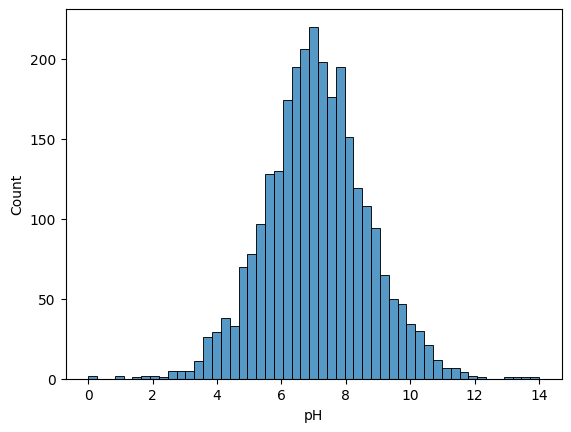

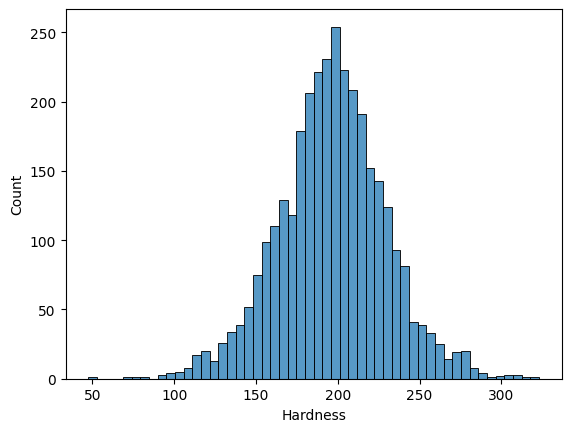

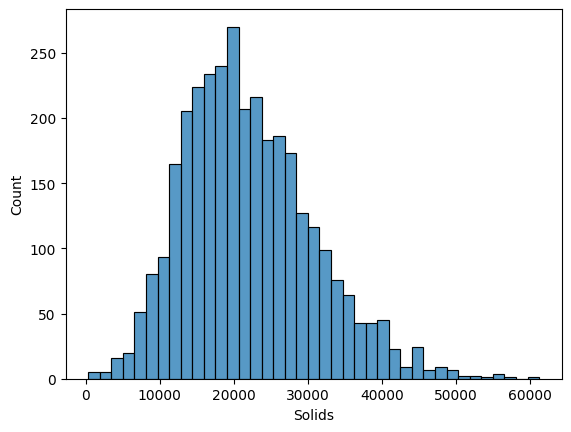

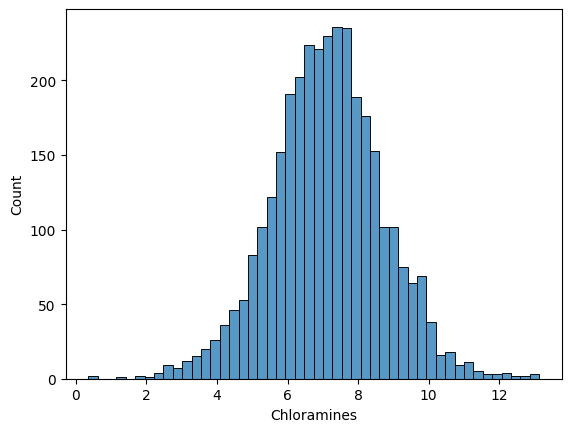

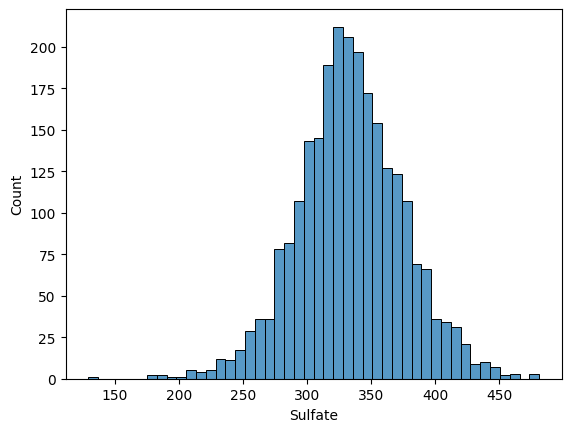

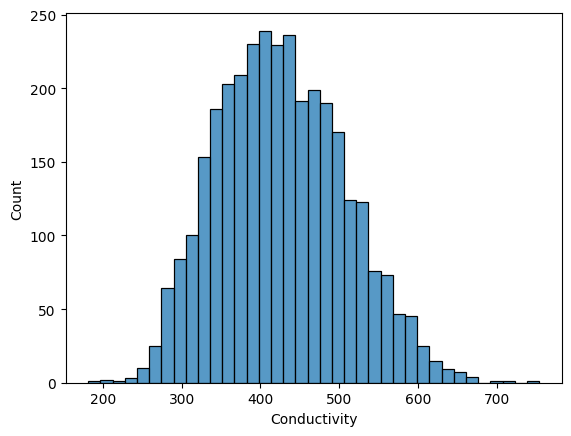

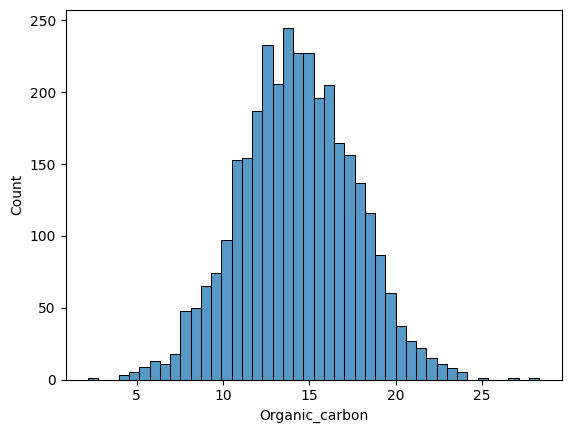

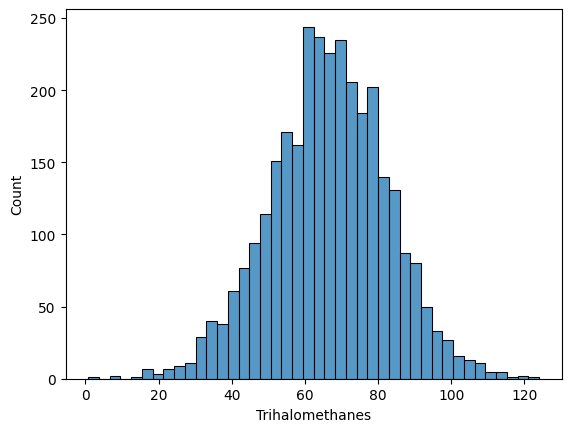

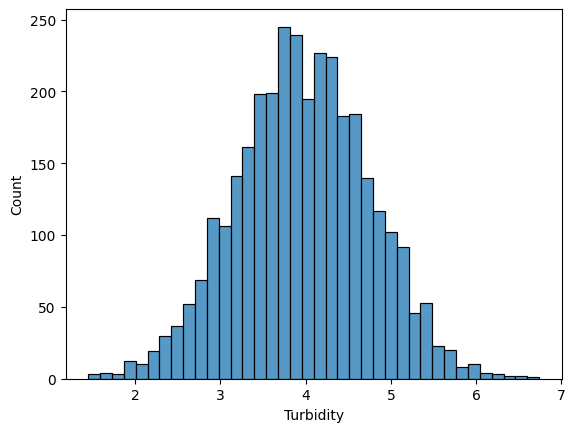

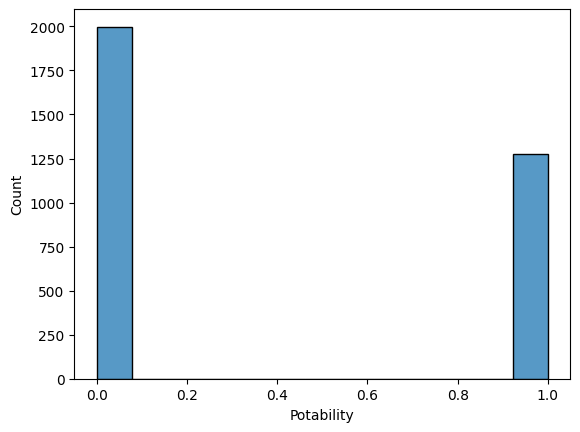

In [86]:
features_tovisualize = features.copy()
for col in features_tovisualize + [target_column]:
    plt.figure()
    sns.histplot(data=df, x=col)

In [87]:
duplicate_rows = df[df.duplicated()]
print("Duplikati:")
print(duplicate_rows)

Duplikati:
Empty DataFrame
Columns: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []


## Pregled tipa feature-a

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Iz ovog mozemo da zakljucimo da nam nije potrebno konvertovanje tipa feature-a iz kategorickih u numericke vrednosti, tako da taj postupak preskacemo. 

## Matrica korelacije - pregled medjusobne zavisnosti kolona

<Axes: >

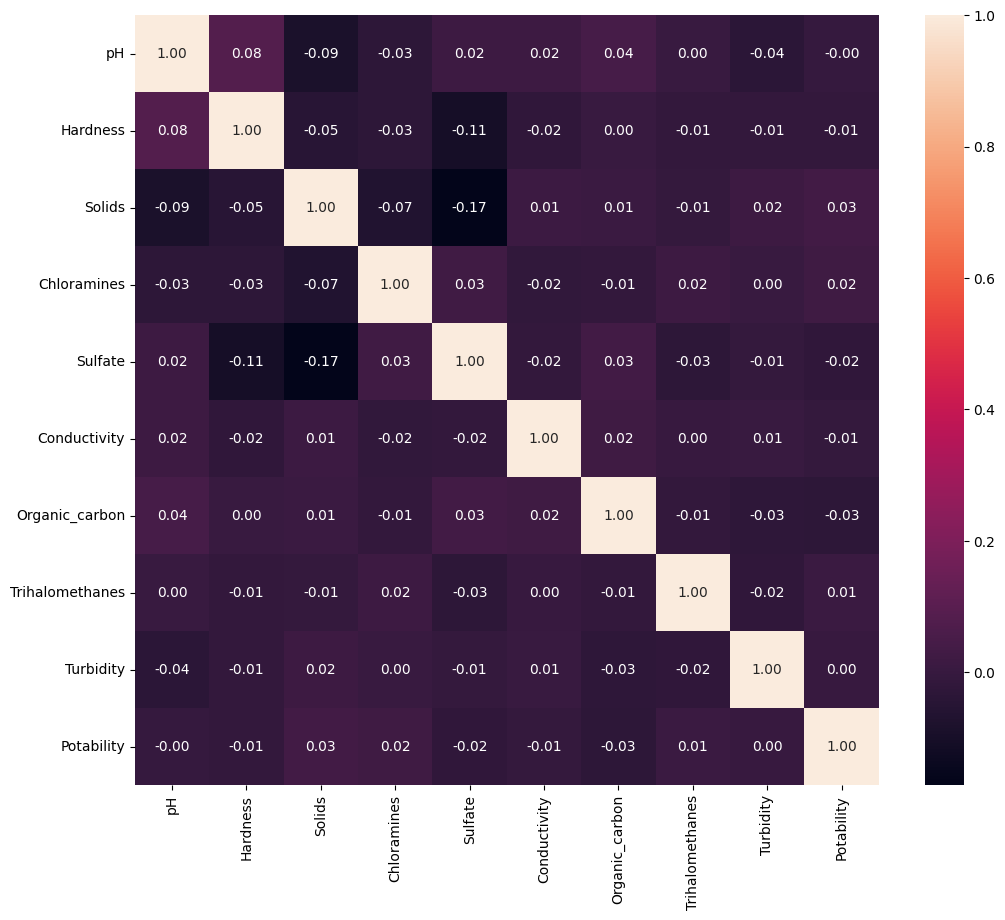

In [89]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Ovde mozemo da vidimo da nijedna kolona nema preveliku korelacioju s ostalim kolonama, osim kolone Solids za koju smo vec rekli da vidimo malo vece odstupanje u opsegu i prosecnom vrednoscu u zavisnosti od toga da li je voda pitka.

## Analiza nedostajucih vrednosti

In [90]:
df.isnull().sum()

pH                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Mozemo da vidimo da postoje tri kolone koje imaju null vrednosti, i od toga 2/3 kolone deluju kao da su znacajne za ceo dataset sto mozemo da vidimo kasnije, tako da ce handlovanje nedostajucih vrednosti dosta da utice na preciznost celokupnog dataseta.

In [91]:
df.describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Ovde vidimo da su vrednosti razlicitog opsega za svaku kolonu, tako da ce najverovatnije biti neophodna normalizacija podataka u kasnijim koracima.

## Brisanje redova koji imaju sve tri prazne kolone 

In [92]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

print("Redovi sa tri null kolona:")
rows_with_multiple_nulls.describe()

Redovi sa tri null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,9.000000,9.000000,9.000000,0.0,9.000000,9.000000,0.0,9.000000,9.000000
mean,NaN,197.615548,22256.806396,6.832987,NaN,448.285723,13.164470,NaN,3.894027,0.111111
std,NaN,28.865246,11891.655823,1.436351,NaN,95.851968,3.088826,NaN,0.624907,0.333333
min,NaN,143.300200,11954.700730,4.933662,NaN,293.477998,8.816487,NaN,3.017985,0.000000
25%,NaN,184.993731,16162.262307,6.087949,NaN,391.238714,11.318807,NaN,3.451740,0.000000
50%,NaN,202.079864,17777.100086,6.657053,NaN,448.846036,12.934160,NaN,3.832479,0.000000
75%,NaN,221.620058,20944.620814,7.627524,NaN,538.621803,13.744749,NaN,4.439215,0.000000
max,NaN,229.771350,44982.734155,8.898024,NaN,566.339294,19.585497,NaN,4.863378,1.000000


Vidimo da imamo 9 redova koji imaju te tri kolone sa null vrednostima, tako da brisanje istih nece mnogo da utice na celokupan dataset.

In [93]:
df = df.drop(rows_with_multiple_nulls.index)

## Imputiranje praznih vrednosti 

### Metoda imputacije: Mean po grupama (Group Mean Imputation)

Imputacija je proces popunjavanja nedostajucih vrednosti u datasetu. Postoji vise pristupa:
U nasem slucaju, hemijske karakteristike vode se razlikuju u zavisnosti od toga da li je voda pitka ili ne. Na primer, pitka voda ima drugaciji prosecni pH od nepitke. Zato grupno imputiranje (po Potability klasi) bolje cuva prirodnu strukturu podataka.

Ova metoda se kasnije pokazala kao najefektivnija za preciznost modela.

In [94]:
df['pH']=df['pH'].fillna(df.groupby(['Potability'])['pH'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

In [95]:
# Evaluate models after imputation
clear_preprocessing_results()
evaluate_models_after_step(df, "1. Nakon imputacije")


EVALUACIJA: 1. Nakon imputacije
Dataset: 3267 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1990), 1: np.int64(1277)}
  DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
  RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
  ExtraTrees         | Accuracy: 0.7123 (+/- 0.0155)
  XGBoost            | Accuracy: 0.7891 (+/- 0.0158)
  LightGBM           | Accuracy: 0.7879 (+/- 0.0167)
  CatBoost           | Accuracy: 0.8118 (+/- 0.0146)
  KNN                | Accuracy: 0.6253 (+/- 0.0177)
  SVM                | Accuracy: 0.6774 (+/- 0.0155)

  NAJBOLJI: CatBoost (0.8118)


,Step,Model,Accuracy_Mean,Accuracy_Std
0,1. Nakon imputacije,DecisionTree,0.725122,0.021669
1,1. Nakon imputacije,RandomForest,0.794305,0.018610
2,1. Nakon imputacije,ExtraTrees,0.712274,0.015473
3,1. Nakon imputacije,XGBoost,0.789097,0.015808
4,1. Nakon imputacije,LightGBM,0.787874,0.016712
5,1. Nakon imputacije,CatBoost,0.811751,0.014619
6,1. Nakon imputacije,KNN,0.625343,0.017676
7,1. Nakon imputacije,SVM,0.677382,0.015534


In [96]:
df.isnull().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Kao sto vidimo, vrednosti su uspesno popunjene i vise nemamo praznih kolona. Sada mozemo da vidimo kako izgledaju podaci u zavisnosti od ciljne kolone - Potability.

In [97]:
df[df['Potability']==0].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.0
mean,7.085378,196.702451,21772.552012,7.092913,334.564290,426.671628,14.372386,66.303555,3.965866,0.0
std,1.548594,31.089068,8527.779592,1.501323,32.006042,79.982881,3.336573,15.674049,0.780915,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.217350,177.756096,15663.057382,6.156857,319.266920,368.498530,12.118536,56.404562,3.444062,0.0
50%,7.085378,197.090572,20827.950711,7.090334,334.564290,422.229331,14.310837,66.303555,3.949117,0.0
75%,7.945026,216.106273,27006.249009,8.066462,348.396008,480.580767,16.660188,76.599159,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


In [98]:
df[df['Potability']==1].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.0
mean,7.073783,195.841857,22388.784145,7.170074,332.566990,425.322500,14.156645,66.539684,3.968733,1.0
std,1.344479,35.530558,9102.961906,1.703452,41.881787,82.051309,3.261649,15.978198,0.781014,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351287,174.480427,15668.273618,6.093750,312.982727,360.932804,12.032377,56.910254,3.430167,1.0
50%,7.073783,196.649823,21208.618285,7.217409,332.566990,420.594592,14.162010,66.539684,3.958609,1.0
75%,7.780869,218.062384,27977.673208,8.199318,354.821194,484.104784,16.352858,77.079780,4.510578,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


In [99]:
df.groupby('Potability').mean().T

Potability,0,1
pH,7.085378,7.073783
Hardness,196.702451,195.841857
Solids,21772.552012,22388.784145
Chloramines,7.092913,7.170074
Sulfate,334.564290,332.566990
Conductivity,426.671628,425.322500
Organic_carbon,14.372386,14.156645
Trihalomethanes,66.303555,66.539684
Turbidity,3.965866,3.968733


Iz ovih podataka mozemo da uocimo da dataset nije balansiran, postoje vise slogova gde je voda oznacena kao nepitka, a i sam raspon vrednosti se razlikuje, pogotovo za kolonu Solids i Hardness. Sada mozemo da kreiramo i matricu korelacije da vidimo koja je medjusobna zavinost svih tih kolona:

<Axes: >

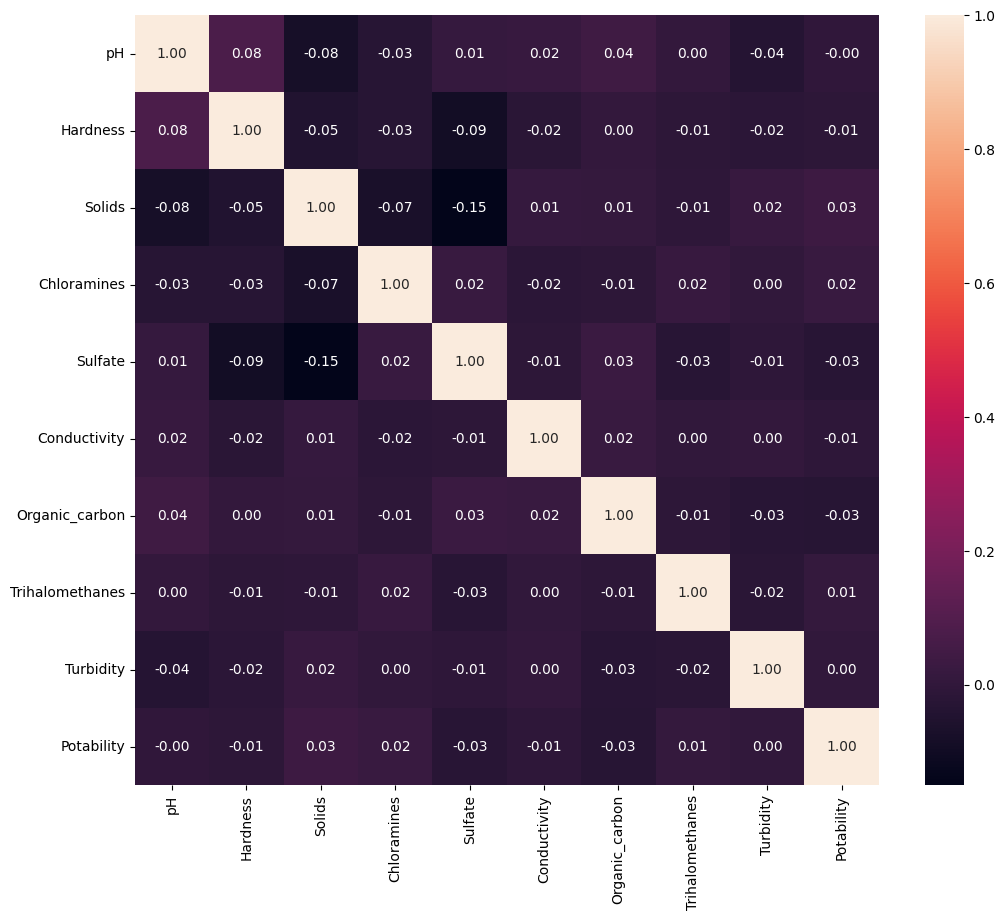

In [100]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Nakon izvrsenog imputiranja praznih vrednosti, vidimo da se korelacija u krajnjem slucaju jos vise smanjila, sto je mozda i ocekivano.

Izvucicemo sve feature-e da bismo lakse izvukli šumove po svakoj koloni:

In [101]:
numerical_features = df.columns.tolist()

### Metode detekcije outliera

| Metoda | Formula | Prag | Osetljivost |
|--------|---------|------|-------------|
| **Z-score** | (x - mean) / std | \|z\| > 3 | Niska (3 std od proseka) |
| **IQR** | Q1 - 1.5*IQR, Q3 + 1.5*IQR | Van opsega | Visoka |
| **Mod Z-score** | 0.6745(xi – x̃) / MAD | -3.5 > x > 3.5| Srednja |

- Vazno jer imamo relativno mali dataset (~3000 uzoraka) i ne mozemo sebi dozvoliti da izgubimo previse podataka
- RandomForest i ostali tree-based modeli su otporni na outliere, ali brisanje outliera i dalje moze da promeni ishod tacnosti modela

In [102]:
def outliers_iqr(x: pd.Series):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def outliers_z_score(ys: pd.Series):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]


outliers = {}
print("Outliers:",' ' * 26,"IQR ZScore ModZScore")
for col in numerical_features:
    outliersIQR = outliers_iqr(df[col])
    outliersZScore = outliers_z_score(df[col])
    outliersModZScore = outliers_modified_z_score(df[col])
    outliers[col] = (outliersIQR, outliersZScore, outliersModZScore)
    print(f"Column '{col:24}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
print()



Outliers:                            IQR ZScore ModZScore
Column 'pH                      ':   142     27        36
Column 'Hardness                ':    83     18        13
Column 'Solids                  ':    46     20        10
Column 'Chloramines             ':    61     20        13
Column 'Sulfate                 ':   261     34       110
Column 'Conductivity            ':    11      7         1
Column 'Organic_carbon          ':    25      4         3
Column 'Trihalomethanes         ':    53     18         5
Column 'Turbidity               ':    19      8         1
Column 'Potability              ':     0      0         0



Od tri metode koje smo iskoristili, Z-score je "najmanje osetljiv" na sumove sto nam odgovara, jer ne smemo da brisemo previse redova zbog manjka podataka s kojim raspolazemo.

In [103]:
z_scores = np.abs((df - df.mean()) / df.std())

# threshold for Z-scores
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
# remove outliers
df_no_outliers = df[~outliers]


In [104]:
# Evaluate models after outlier removal
evaluate_models_after_step(df_no_outliers, "2. Bez outliera")


EVALUACIJA: 2. Bez outliera
Dataset: 3121 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1923), 1: np.int64(1198)}
  DecisionTree       | Accuracy: 0.7200 (+/- 0.0190)
  RandomForest       | Accuracy: 0.7985 (+/- 0.0125)
  ExtraTrees         | Accuracy: 0.6982 (+/- 0.0132)
  XGBoost            | Accuracy: 0.7895 (+/- 0.0203)
  LightGBM           | Accuracy: 0.7866 (+/- 0.0129)
  CatBoost           | Accuracy: 0.8039 (+/- 0.0186)
  KNN                | Accuracy: 0.6197 (+/- 0.0113)
  SVM                | Accuracy: 0.6706 (+/- 0.0168)

  NAJBOLJI: CatBoost (0.8039)


,Step,Model,Accuracy_Mean,Accuracy_Std
0,2. Bez outliera,DecisionTree,0.719959,0.019029
1,2. Bez outliera,RandomForest,0.798464,0.012527
2,2. Bez outliera,ExtraTrees,0.698179,0.013212
3,2. Bez outliera,XGBoost,0.789501,0.020268
4,2. Bez outliera,LightGBM,0.786612,0.012868
5,2. Bez outliera,CatBoost,0.803912,0.018586
6,2. Bez outliera,KNN,0.619677,0.011299
7,2. Bez outliera,SVM,0.670622,0.016842


<Axes: xlabel='Potability', ylabel='Count'>

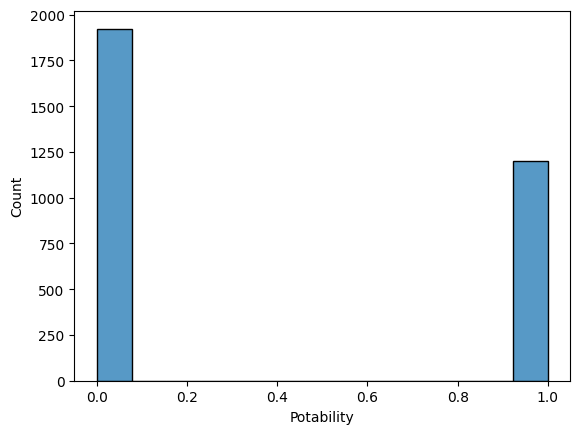

In [105]:
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies

plt.figure()
sns.histplot(data=df_no_outliers, x="Potability")

In [106]:
# df = df_no_outliers  

## Balansiranje klasa (Resampling)

Nebalansirane klase su cest problem u klasifikaciji. U nasem datasetu imamo vise nepitke vode (~60%) nego pitke (~40%). Ovo moze navesti model da "favorizuje" vecinu klasu.
Upsampling koristimo da bismo pokusali da dobijemo sto vise podataka, jer bismo u suprotnom izgubili dosta podataka.
Nakon balansiranja imamo jednak broj uzoraka za obe klase, sto omogucava modelu da ravnomerno uci oba ishoda.

In [107]:
# Balansiranje klasa - upsampling manjinske klase
from sklearn.utils import resample, shuffle

class_0 = df[df['Potability'] == 0]
class_1 = df[df['Potability'] == 1]

# Dinamicki odrediti n_samples kao max od obe klase
n_samples = max(len(class_0), len(class_1))

# Upsampling manjinske klase
if len(class_0) < len(class_1):
    class_0 = resample(class_0, replace=True, n_samples=n_samples, random_state=42)
else:
    class_1 = resample(class_1, replace=True, n_samples=n_samples, random_state=42)

df = pd.concat([class_0, class_1])
df = shuffle(df, random_state=42)

print(f"Klasa 0: {len(class_0)}, Klasa 1: {len(class_1)}")
print(f"Ukupno nakon balansiranja: {len(df)}")

Klasa 0: 1990, Klasa 1: 1990
Ukupno nakon balansiranja: 3980


<Axes: ylabel='count'>

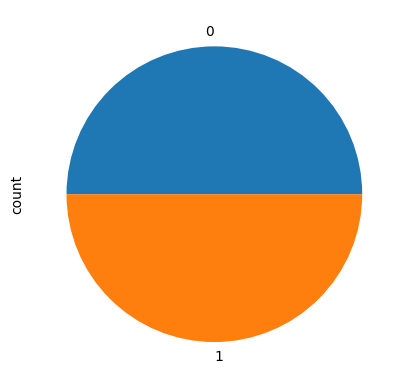

In [108]:
df.Potability.value_counts().plot(kind ='pie')

In [109]:
# Evaluate models after balancing - compare before and after
clear_preprocessing_results()

# After balancing (using df which is now balanced)
evaluate_models_after_step(df, "Posle balansiranja (upsampling)", show_plot=False)


EVALUACIJA: Posle balansiranja (upsampling)
Dataset: 3980 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1990), 1: np.int64(1990)}
  DecisionTree       | Accuracy: 0.8367 (+/- 0.0149)
  RandomForest       | Accuracy: 0.8839 (+/- 0.0103)
  ExtraTrees         | Accuracy: 0.8666 (+/- 0.0161)
  XGBoost            | Accuracy: 0.8736 (+/- 0.0102)
  LightGBM           | Accuracy: 0.8704 (+/- 0.0108)
  CatBoost           | Accuracy: 0.8636 (+/- 0.0150)
  KNN                | Accuracy: 0.6719 (+/- 0.0173)
  SVM                | Accuracy: 0.6990 (+/- 0.0141)

  NAJBOLJI: RandomForest (0.8839)


,Step,Model,Accuracy_Mean,Accuracy_Std
0,Posle balansiranja (upsampling),DecisionTree,0.836683,0.014907
1,Posle balansiranja (upsampling),RandomForest,0.883920,0.010286
2,Posle balansiranja (upsampling),ExtraTrees,0.866583,0.016057
3,Posle balansiranja (upsampling),XGBoost,0.873618,0.010225
4,Posle balansiranja (upsampling),LightGBM,0.870352,0.010760
5,Posle balansiranja (upsampling),CatBoost,0.863568,0.014962
6,Posle balansiranja (upsampling),KNN,0.671859,0.017251
7,Posle balansiranja (upsampling),SVM,0.698995,0.014137


In [110]:
print('Counts of rows by class:')
print(df[target_column].value_counts())


Counts of rows by class:
Potability
0    1990
1    1990
Name: count, dtype: int64


In [111]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features, '\n')


There are 10 numerical features:
['pH', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'] 



In [112]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000
mean,7.066204,196.180311,22147.584569,7.138424,333.373513,425.101072,14.255069,66.389302,3.968071,0.500000
std,1.445830,33.752241,8842.477959,1.602968,36.907932,81.513846,3.303622,15.691905,0.779222,0.500063
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.260697,175.982447,15761.088680,6.126270,315.968460,364.125188,12.070444,57.014569,3.445574,0.000000
50%,7.073783,196.791251,21217.930733,7.150471,333.133897,421.320293,14.189459,66.421231,3.948659,0.500000
75%,7.837675,217.690352,27655.525663,8.137069,350.864885,480.689096,16.506658,76.648622,4.498069,1.000000
max,14.000000,323.124000,61227.196008,13.127000,476.539717,753.342620,28.300000,124.000000,6.739000,1.000000


In [113]:
minmax_df = df.copy()
minmax_scaler = MinMaxScaler(feature_range=(0,1))
minmax_df[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

minmax_df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000,3980.000000
mean,0.504729,0.539545,0.358365,0.531227,0.588058,0.426010,0.461880,0.532616,0.476096,0.500000
std,0.103274,0.122427,0.145182,0.125477,0.106198,0.142542,0.126576,0.127305,0.147329,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.447193,0.466283,0.253507,0.451998,0.537977,0.319382,0.378178,0.456561,0.377307,0.000000
50%,0.505270,0.541761,0.343101,0.532170,0.587369,0.419398,0.459366,0.532875,0.472426,0.500000
75%,0.559834,0.617567,0.448798,0.609399,0.638387,0.523215,0.548148,0.615848,0.576303,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
std_df = df.copy()
std_scaler = StandardScaler()
std_df[numerical_features] = std_scaler.fit_transform(df[numerical_features])
std_df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3.980000e+03,3.980000e+03,3.980000e+03,3.980000e+03,3.980000e+03,3.980000e+03,3.980000e+03,3.980000e+03,3.980000e+03,3980.000000
mean,-5.141616e-16,-1.963812e-17,1.919179e-16,2.802895e-16,-1.213993e-16,2.758263e-16,3.186731e-16,-8.372978e-16,2.186972e-17,0.000000
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126
min,-4.887913e+00,-4.407618e+00,-2.468695e+00,-4.234193e+00,-5.538083e+00,-2.989037e+00,-3.649504e+00,-4.184294e+00,-3.231924e+00,-1.000000
25%,-5.571946e-01,-5.984907e-01,-7.223426e-01,-6.315044e-01,-4.716395e-01,-7.481373e-01,-6.613646e-01,-5.974998e-01,-6.706203e-01,-1.000000
50%,5.242844e-03,1.810299e-02,-1.051482e-01,7.516086e-03,-6.493082e-03,-4.638788e-02,-1.986236e-02,2.035031e-03,-2.491488e-02,0.000000
75%,5.336505e-01,6.373723e-01,6.229739e-01,6.230754e-01,4.739786e-01,6.820315e-01,6.816373e-01,6.538791e-01,6.802486e-01,1.000000
max,4.796323e+00,3.761517e+00,4.420087e+00,3.736399e+00,3.879496e+00,4.027326e+00,4.251907e+00,3.671825e+00,3.556466e+00,1.000000


In [115]:
rbst_df = df.copy()
rbst_scaler = RobustScaler()
rbst_df[numerical_features] = rbst_scaler.fit_transform(df[numerical_features])
rbst_df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3980.000000,3980.000000,3.980000e+03,3.980000e+03,3980.000000,3980.000000,3.980000e+03,3.980000e+03,3.980000e+03,3980.000000
mean,-0.004806,-0.014648,7.815871e-02,-5.990919e-03,0.006866,0.032435,1.478953e-02,-1.626231e-03,1.844360e-02,0.000000
std,0.916836,0.809253,7.434129e-01,7.971798e-01,1.057642,0.699306,7.446941e-01,7.992188e-01,7.403573e-01,0.500063
min,-4.485656,-3.581078,-1.756871e+00,-3.380980e+00,-5.849708,-2.057554,-2.702633e+00,-3.345373e+00,-2.374034e+00,-0.500000
25%,-0.515598,-0.498918,-4.587726e-01,-5.093502e-01,-0.491897,-0.490676,-4.776630e-01,-4.790994e-01,-4.779927e-01,-0.500000
50%,0.000000,0.000000,-1.529403e-16,-2.208520e-16,0.000000,0.000000,-2.002115e-16,3.618931e-16,-2.109857e-16,0.000000
75%,0.484402,0.501082,5.412274e-01,4.906498e-01,0.508103,0.509324,5.223370e-01,5.209006e-01,5.220073e-01,0.500000
max,4.392081,3.028988,3.363696e+00,2.972216e+00,4.109470,2.848415,3.180762e+00,2.932597e+00,2.651168e+00,0.500000


In [116]:
X = df.drop(["Potability"],axis=1)
y = df["Potability"]

In [117]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_0': make_scorer(precision_score, pos_label=0),
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_0': make_scorer(recall_score, pos_label=0),
    'recall_1': make_scorer(recall_score, pos_label=1),
    'f1_0': make_scorer(f1_score, pos_label=0),
    'f1_1': make_scorer(f1_score, pos_label=1),
    'roc_auc': 'roc_auc'
}

Koristicemo metodu podele podataka na 20-80.

In [118]:
# Split the data into training and testing sets
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialize models (bez NeuralNetwork)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': svm.SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'NaiveBayes': GaussianNB(),
    'XGBoost': XGBClassifier(verbose=0),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LGBMClassifier': LGBMClassifier(verbose=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100, random_state=5),
    'CatBoostClassifier': CatBoostClassifier(verbose=0)
}

# Initialize a dictionary to store results
results = {}

# Loop through each scaler and model, apply them, and evaluate performance
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        results[(model_name, scaler_name)] = accuracy

# Add results for models without normalization
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[(model_name, 'NoScaler')] = accuracy


c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:13:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:13:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

In [119]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

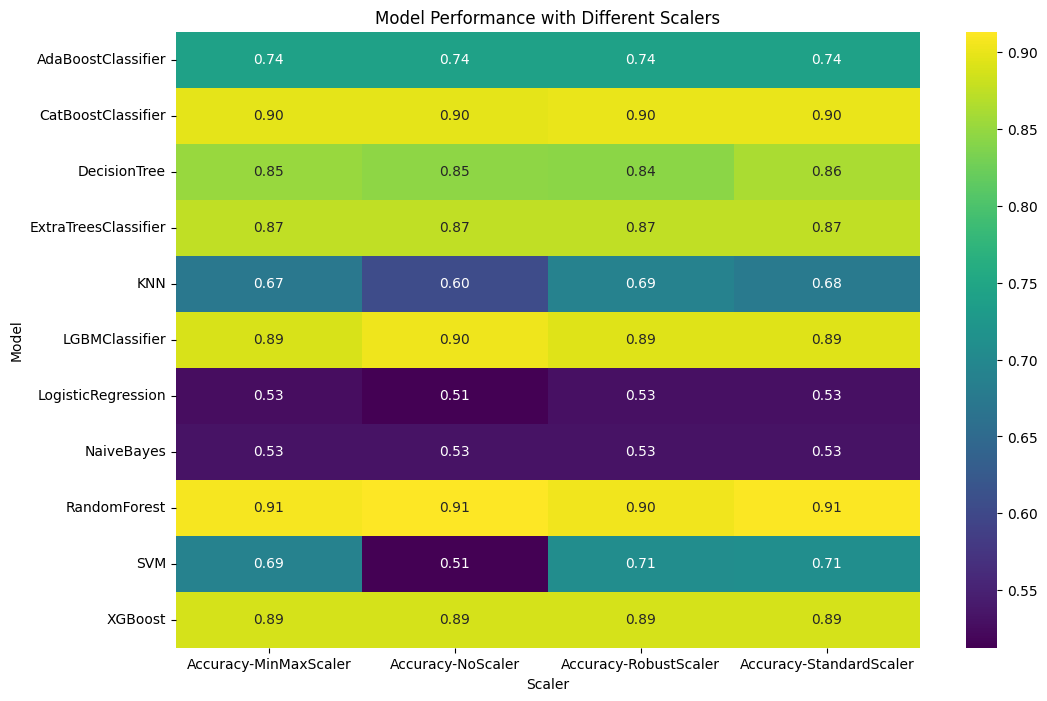

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# create a heatmap
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".2f")

plt.title('Model Performance with Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Model')

plt.show()

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Initialize scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': svm.SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'NaiveBayes': GaussianNB(),
    'XGBoost': XGBClassifier(verbose=0),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LGBMClassifier': LGBMClassifier(verbose=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100, random_state=5),
    'CatBoostClassifier': CatBoostClassifier(random_state= 42, verbose=0)
}
results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    
    for model_name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=kf)
        results[(model_name, scaler_name)] = scores.mean()

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf)
    results[(model_name, 'NoScaler')] = scores.mean()


c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboos

In [122]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

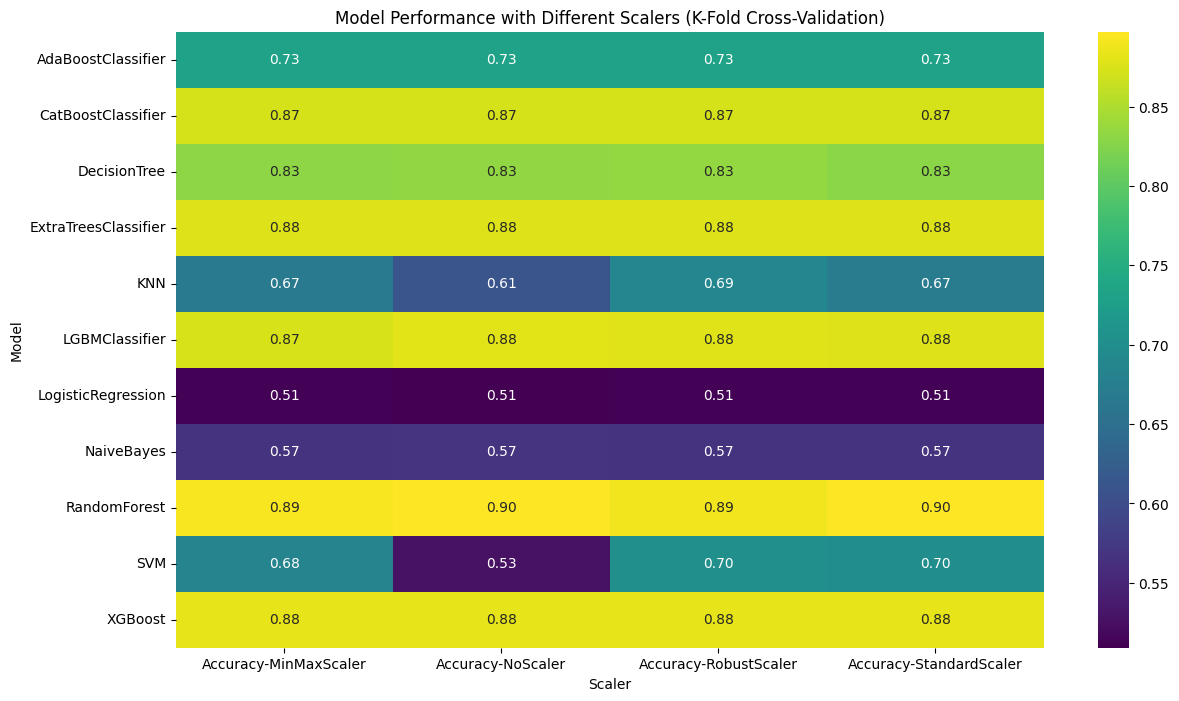

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".2f")

plt.title('Model Performance with Different Scalers (K-Fold Cross-Validation)')
plt.xlabel('Scaler')
plt.ylabel('Model')

plt.show()

## Optimizacija hiperparametara

### GridSearchCV vs RandomizedSearchCV
Random Forest hiperparametri:

| Parametar | Opis | Tipicne vrednosti |
|-----------|------|-------------------|
| `n_estimators` | Broj stabala u sumi | 100-500 |
| `max_depth` | Maksimalna dubina stabla | 10-50 ili None |
| `min_samples_split` | Min uzoraka za deljenje cvora | 2-10 |
| `min_samples_leaf` | Min uzoraka u listu | 1-4 |
| `max_features` | Broj osobina po stablu | 'sqrt', 'log2', None |


In [124]:
from scipy.stats import truncnorm, randint

from scipy import stats

# Parametri za RandomForest optimizaciju
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [125]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)

In [126]:
print(f"Optimizing hyperparameters with a grid search...")
startTime = time.perf_counter()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search.fit(X_train_scaled, y_train)
endTime = time.perf_counter()
print(f"Parameters optimized in {endTime - startTime:0.4f} seconds.")

best_random_params = grid_search.best_params_

Optimizing hyperparameters with a grid search...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Parameters optimized in 120.2061 seconds.


In [127]:
print(best_random_params)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [128]:
# Get best model from grid search
best_rf = grid_search.best_estimator_
rf_best = best_rf  # Alias for SHAP, LIME, Feature Importance

# Predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_rf = y_pred  # Alias for later cells
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (pitka)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {rf_accuracy:.4f}")

# ROC curve data
from sklearn.metrics import roc_curve, roc_auc_score
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC Score: {roc_auc_rf:.4f}")

Test set accuracy: 0.9183
AUC Score: 0.9705


In [129]:
def test_model(model, X: pd.DataFrame, Y: pd.DataFrame):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(model, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']
    F10Scores = cv_results['test_f1_0']
    F11Scores = cv_results['test_f1_1']

    return { 
        'Accuracy': np.mean(AccuScores),
        'Precision 0': np.mean(Prec0Scores),
        'Precision 1': np.mean(Prec1Scores),
        'Recall 0': np.mean(Rec0Scores),
        'Recall 1': np.mean(Rec1Scores),
        'F1 0': np.mean(F10Scores),
        'F1 1': np.mean(F11Scores)
    }

## Evaluacija najboljeg modela
Matrica konfuzije, Feature Importance, ROC kriva i AUC score.

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42
)

# Skaliranje podataka
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Treniranje
best_model.fit(X_train_final, y_train_final)
y_pred_final = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

print(classification_report(y_test_final, y_pred_final, target_names=['Nepitka (0)', 'Pitka (1)']))

              precision    recall  f1-score   support

 Nepitka (0)       0.91      0.90      0.90       390
   Pitka (1)       0.90      0.91      0.91       406

    accuracy                           0.91       796
   macro avg       0.91      0.91      0.91       796
weighted avg       0.91      0.91      0.91       796



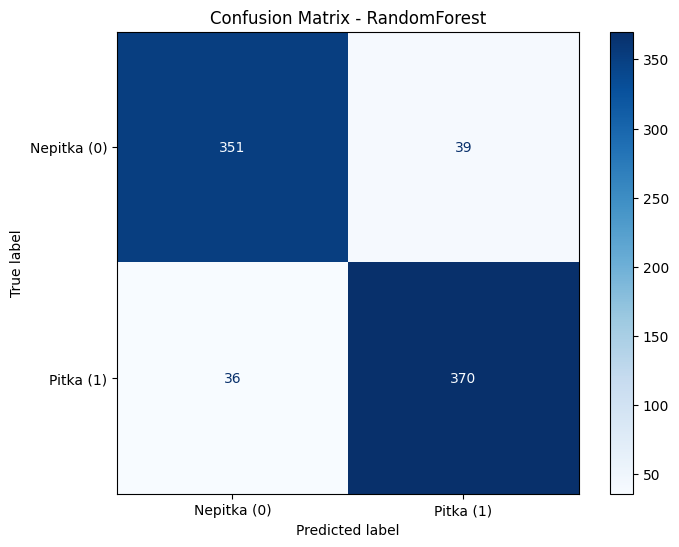


True Negatives (TN): 351
False Positives (FP): 39
False Negatives (FN): 36
True Positives (TP): 370

Accuracy: 0.9058
Precision (Pitka): 0.9046
Recall (Pitka): 0.9113


In [131]:
# Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_final)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - RandomForest')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")

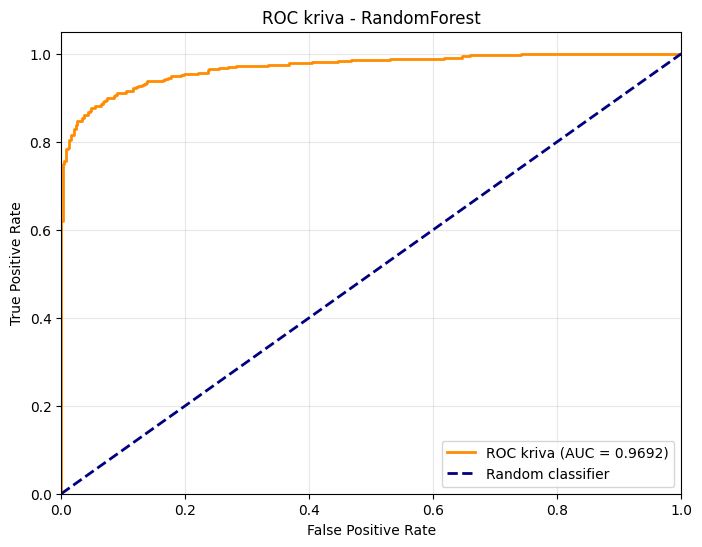

AUC Score: 0.9692


In [132]:
# ROC kriva i AUC
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC kriva (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kriva - RandomForest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### Sumarna tabela: Baseline vs Finalni model

SUMARNA TABELA: BASELINE vs FINALNI MODEL
               Model  Accuracy (CV)      Std      Tip
RandomForest finalni       0.887688 0.010795  Finalni
  CatBoostClassifier       0.686234 0.011689 Baseline
ExtraTreesClassifier       0.683244 0.021057 Baseline
        RandomForest       0.669322 0.029727 Baseline
      LGBMClassifier       0.646445 0.011999 Baseline
             XGBoost       0.643455 0.013272 Baseline
        DecisionTree       0.614116 0.029991 Baseline
        MostFrequent       0.596730 0.027035 Baseline
                 SVM       0.596730 0.027035 Baseline
                 KNN       0.545502 0.015691 Baseline
          Stratified       0.510691 0.019101 Baseline
             Uniform       0.491785 0.026341 Baseline


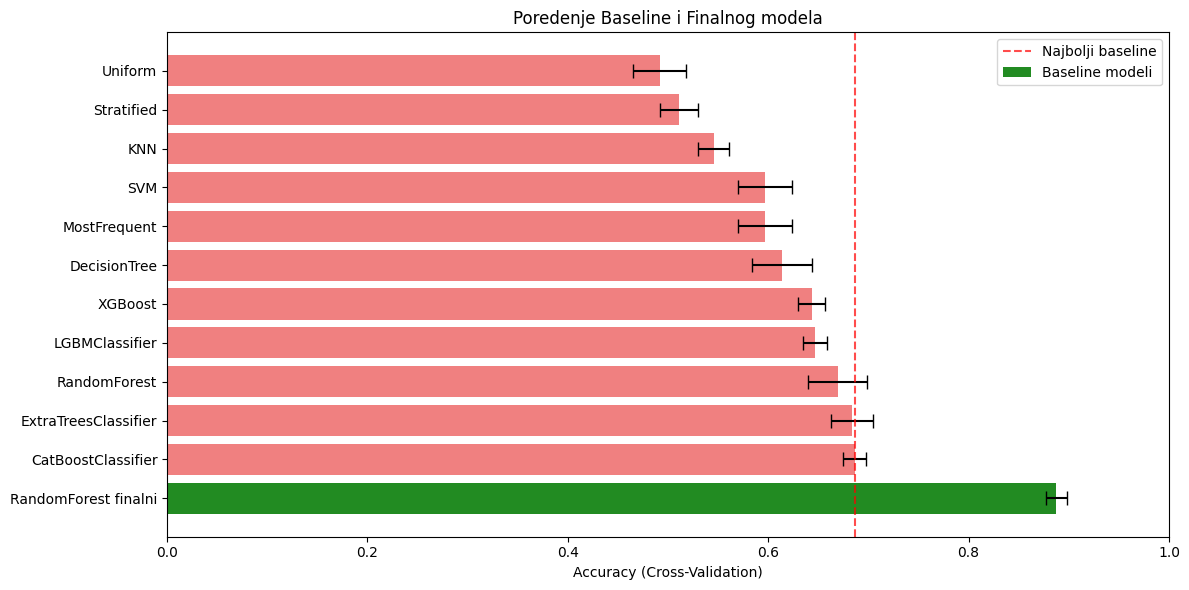


Poboljsanje u odnosu na najbolji baseline: 29.36%
Baseline (best): 0.6862 -> Finalni: 0.8877


In [133]:
# Sumarna tabela: Baseline vs Finalni rezultati
from sklearn.metrics import precision_score, recall_score, f1_score

# Finalni model accuracy (sa CV)
kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
final_model_for_cv = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_leaf=2,
    min_samples_split=2, max_features='sqrt', random_state=42
)
final_cv_scores = cross_val_score(final_model_for_cv, X, y, cv=kf_final)

# Kreiranje sumarne tabele
summary_data = {
    'Model': [],
    'Accuracy (CV)': [],
    'Std': [],
    'Tip': []
}

# Baseline rezultati
for name, result in baseline_results_cv.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy (CV)'].append(result['mean'])
    summary_data['Std'].append(result['std'])
    summary_data['Tip'].append('Baseline')

# Finalni model
summary_data['Model'].append('RandomForest finalni')
summary_data['Accuracy (CV)'].append(final_cv_scores.mean())
summary_data['Std'].append(final_cv_scores.std())
summary_data['Tip'].append('Finalni')

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy (CV)', ascending=False)

print("=" * 70)
print("SUMARNA TABELA: BASELINE vs FINALNI MODEL")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Vizualizacija
plt.figure(figsize=(12, 6))
colors = ['lightcoral' if t == 'Baseline' else 'forestgreen' for t in summary_df['Tip']]
bars = plt.barh(summary_df['Model'], summary_df['Accuracy (CV)'], color=colors, xerr=summary_df['Std'], capsize=5)
plt.xlabel('Accuracy (Cross-Validation)')
plt.title('Poredenje Baseline i Finalnog modela')
plt.xlim(0, 1)
plt.axvline(x=summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max(), 
            color='red', linestyle='--', alpha=0.7, label='Najbolji baseline')
plt.legend(['Najbolji baseline', 'Baseline modeli', 'Finalni model'])
plt.tight_layout()
plt.show()

# Poboljsanje
baseline_best = summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max()
final_acc = summary_df[summary_df['Tip']=='Finalni']['Accuracy (CV)'].values[0]
improvement = ((final_acc - baseline_best) / baseline_best) * 100
print(f"\nPoboljsanje u odnosu na najbolji baseline: {improvement:.2f}%")
print(f"Baseline (best): {baseline_best:.4f} -> Finalni: {final_acc:.4f}")

### Feature Importance (Vaznost osobina)

Feature Importance pokazuje koliko svaka osobina doprinosi predikcijama modela. 
Moze da sadrzi:

- **Visoku vaznost**: Osobina ima veliki uticaj na predikcije
- **Nisku vaznost**: Osobina malo doprinosi - moze se eventualno ukloniti
- **Relativnu vrednost**: Vaznost je normalizovana (suma = 1)

Ocekujemo da hemijski parametri poput pH, Sulfata i tvrdoce vode budu medju najvaznijim jer:
- pH direktno utice na pitkost (7 je neutralno)
- Sulfati u visokim koncentracijama mogu biti stetni
- Tvrdoca vode utice na ukus i upotrebljivost

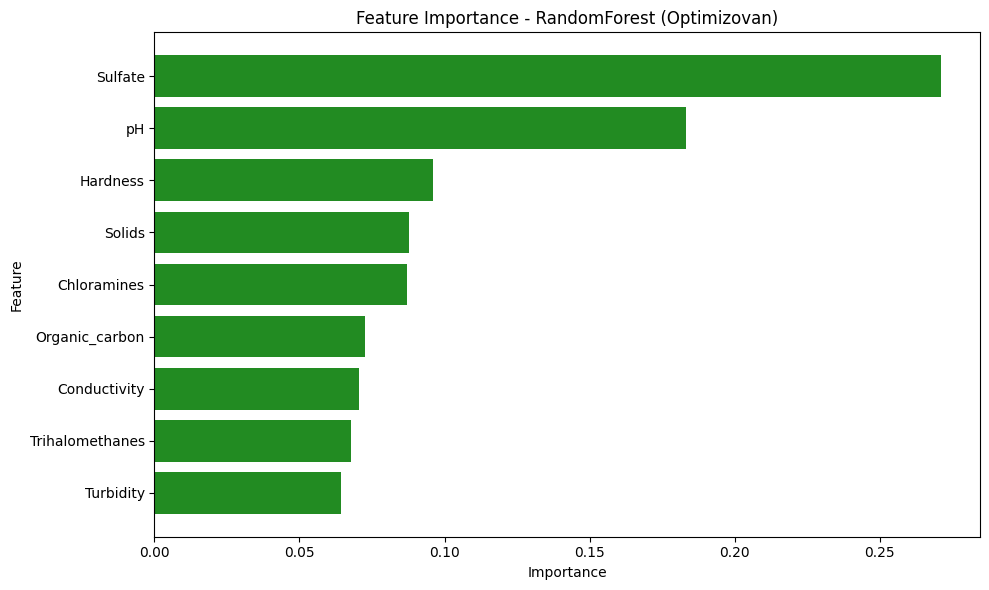


Feature Importance ranking (RandomForest):
  Sulfate: 0.2710
  pH: 0.1832
  Hardness: 0.0958
  Solids: 0.0878
  Chloramines: 0.0870
  Organic_carbon: 0.0725
  Conductivity: 0.0705
  Trihalomethanes: 0.0679
  Turbidity: 0.0643


In [134]:
# Feature Importance - RandomForest
rf_feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['feature'], rf_feature_importance['importance'], color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - RandomForest (Optimizovan)')
plt.tight_layout()
plt.show()

print("\nFeature Importance ranking (RandomForest):")
for idx, row in rf_feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Analiza interpretabilnosti modela (LIME i SHAP)

SHAP racuna doprinos svake osobine predikciji koristeci Shapley vrednosti iz teorije igara:
1. Za svaku osobinu, racuna se koliko bi se predikcija promenila ako tu osobinu "izbacimo"
2. Ovo se radi za sve moguce kombinacije osobina
3. Rezultat je ponderisani prosek doprinosa

LIME (Local Interpretable Model-agnostic Explanations):
1. Uzima instancu koju zelimo objasniti
2. Pravi perturbacije (varijacije) oko te instance
3. Trenira jednostavan linearni model na tim perturbacijama
4. Koeficijenti linearnog modela = objasnjenje


In [135]:
import shap
import lime
import lime.lime_tabular

# Kreiranje SHAP explainer-a za RandomForest
print("Kreiranje SHAP explainer-a...")
explainer_shap = shap.TreeExplainer(rf_best)

# Izracunavanje SHAP vrednosti za test skup
shap_values = explainer_shap.shap_values(X_test_scaled)


Kreiranje SHAP explainer-a...


### SHAP Summary Plot
Summary plot prikazuje uticaj svake osobine na predikcije modela. Svaka tacka predstavlja jedan uzorak, a boja pokazuje vrednost osobine (crvena = visoka, plava = niska).

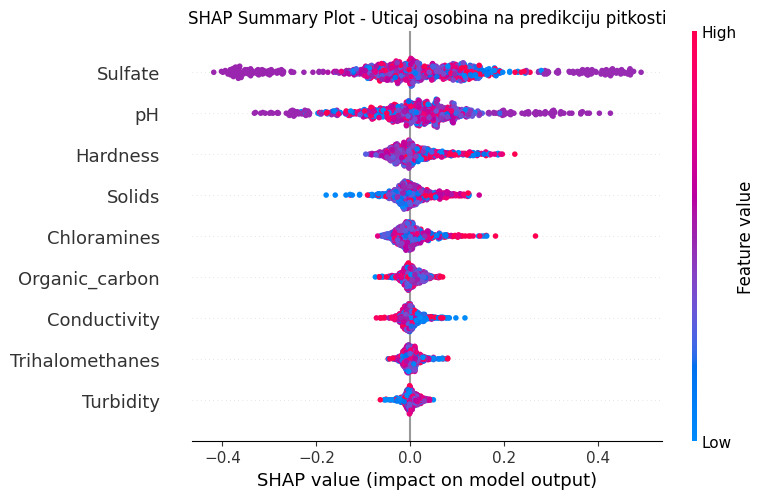

In [136]:
# SHAP Summary Plot - za klasu 1 (pitka voda)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[:, :, 1], X_test_scaled, feature_names=features, show=False)
plt.title('SHAP Summary Plot - Uticaj osobina na predikciju pitkosti')
plt.tight_layout()
plt.show()

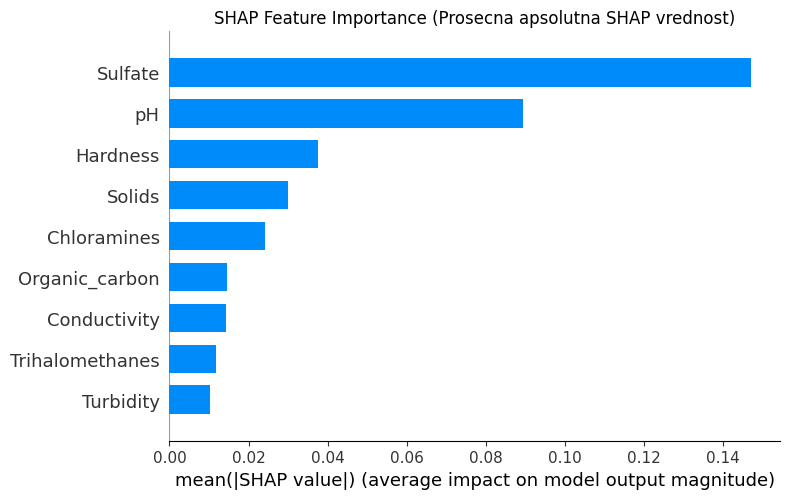

In [137]:
# SHAP Bar Plot - prosecna apsolutna vrednost SHAP vrednosti
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:, :, 1], X_test_scaled, feature_names=features, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Prosecna apsolutna SHAP vrednost)')
plt.tight_layout()
plt.show()

### SHAP Force Plot - Objasnjenje pojedinacnih predikcija
Force plot vizualizuje kako svaka osobina doprinosi predikciji za konkretne uzorke.

=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===
Uzorak index: 0
Prava klasa: 1
Predvidjena klasa: 1
Verovatnoca pitkosti: 0.9044


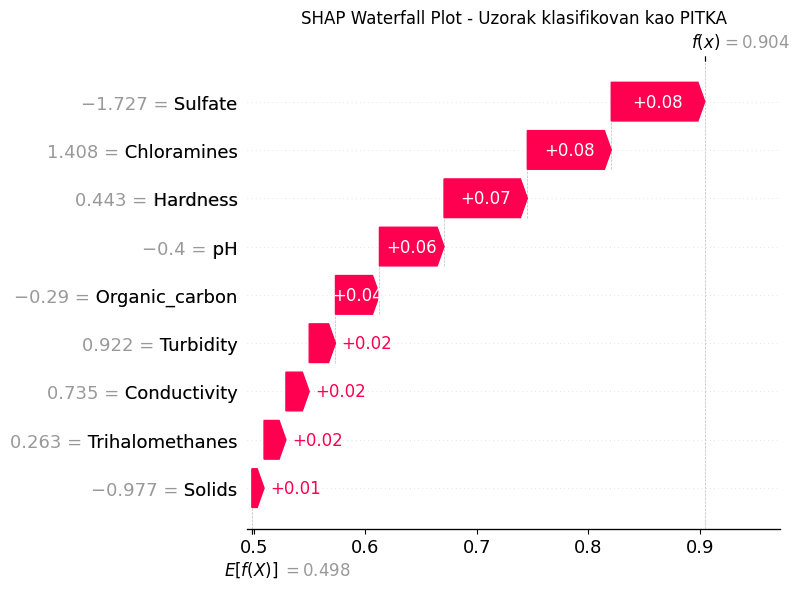

In [138]:
# Force plot za prvi uzorak koji je klasifikovan kao pitka voda
# Pronalazenje uzorka klasifikovanog kao pitka voda (klasa 1)
pitka_indices = np.where(y_pred_rf == 1)[0]
nepitka_indices = np.where(y_pred_rf == 0)[0]

print("=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===")
sample_idx = pitka_indices[0]
print(f"Uzorak index: {sample_idx}")
print(f"Prava klasa: {y_test.iloc[sample_idx]}")
print(f"Predvidjena klasa: {y_pred_rf[sample_idx]}")
print(f"Verovatnoca pitkosti: {y_pred_proba_rf[sample_idx]:.4f}")

# SHAP waterfall plot
shap.initjs()
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx, :, 1],
    base_values=explainer_shap.expected_value[1],
    data=X_test_scaled[sample_idx],
    feature_names=features
), show=False)
plt.title(f'SHAP Waterfall Plot - Uzorak klasifikovan kao PITKA')
plt.tight_layout()
plt.show()

=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===
Uzorak index: 2
Prava klasa: 0
Predvidjena klasa: 0
Verovatnoca pitkosti: 0.2252


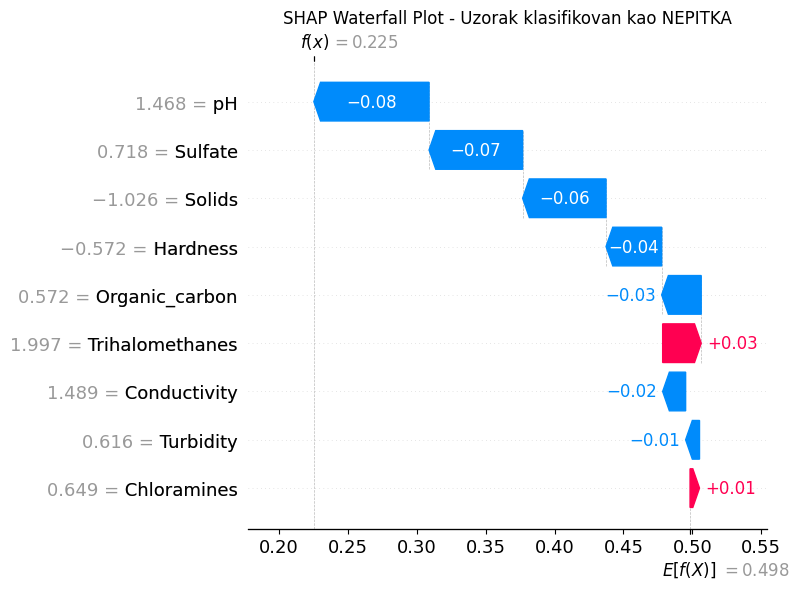

In [139]:
print("=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===")
sample_idx_neg = nepitka_indices[0]
print(f"Uzorak index: {sample_idx_neg}")
print(f"Prava klasa: {y_test.iloc[sample_idx_neg]}")
print(f"Predvidjena klasa: {y_pred_rf[sample_idx_neg]}")
print(f"Verovatnoca pitkosti: {y_pred_proba_rf[sample_idx_neg]:.4f}")

# SHAP waterfall plot za nepitku
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx_neg, :, 1],
    base_values=explainer_shap.expected_value[1],
    data=X_test_scaled[sample_idx_neg],
    feature_names=features
), show=False)
plt.title(f'SHAP Waterfall Plot - Uzorak klasifikovan kao NEPITKA')
plt.tight_layout()
plt.show()

### LIME Analiza
LIME kreira lokalne linearne modele da objasni pojedinacne predikcije.

=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===


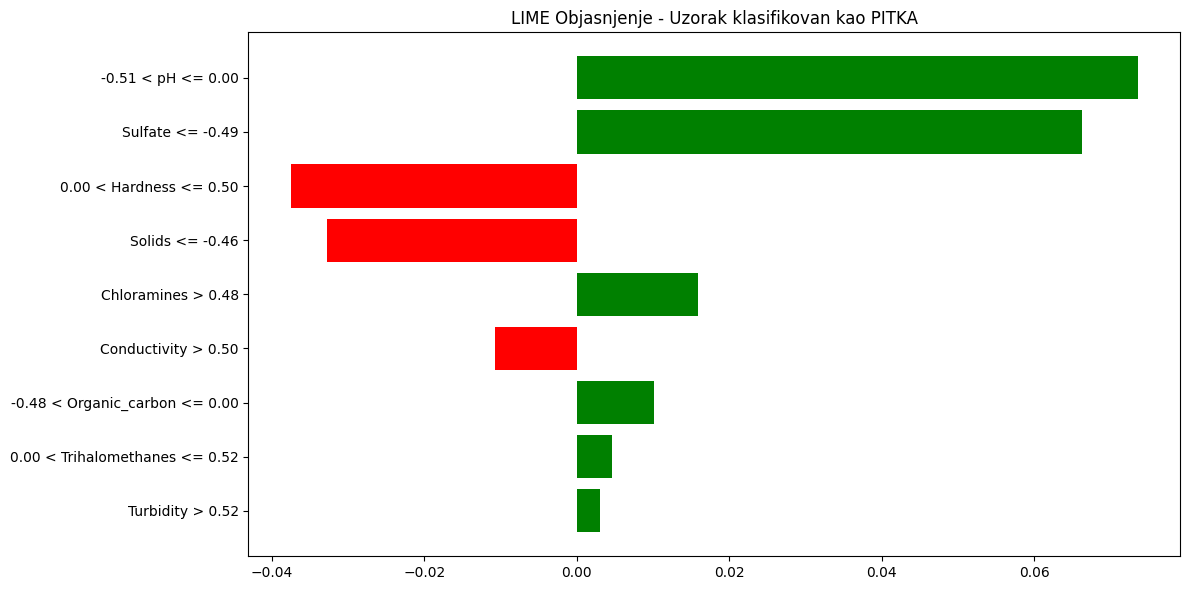


LIME feature weights:
  -0.51 < pH <= 0.00: 0.0735
  Sulfate <= -0.49: 0.0662
  0.00 < Hardness <= 0.50: -0.0375
  Solids <= -0.46: -0.0328
  Chloramines > 0.48: 0.0159
  Conductivity > 0.50: -0.0108
  -0.48 < Organic_carbon <= 0.00: 0.0101
  0.00 < Trihalomethanes <= 0.52: 0.0047
  Turbidity > 0.52: 0.0030


In [140]:
# Kreiranje LIME explainera
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification',
    random_state=42
)

# LIME objasnjenje za uzorak klasifikovan kao pitka voda
print("=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===")
lime_exp_pitka = lime_explainer.explain_instance(
    X_test_scaled[sample_idx],
    rf_best.predict_proba,
    num_features=9
)

# Prikaz LIME objasnjenja
fig = lime_exp_pitka.as_pyplot_figure()
fig.set_size_inches(12, 6)
plt.title('LIME Objasnjenje - Uzorak klasifikovan kao PITKA')
plt.tight_layout()
plt.show()

print("\nLIME feature weights:")
for feat, weight in lime_exp_pitka.as_list():
    print(f"  {feat}: {weight:.4f}")

=== LIME - uzorak klasifikovan kao NEPITKA voda ===


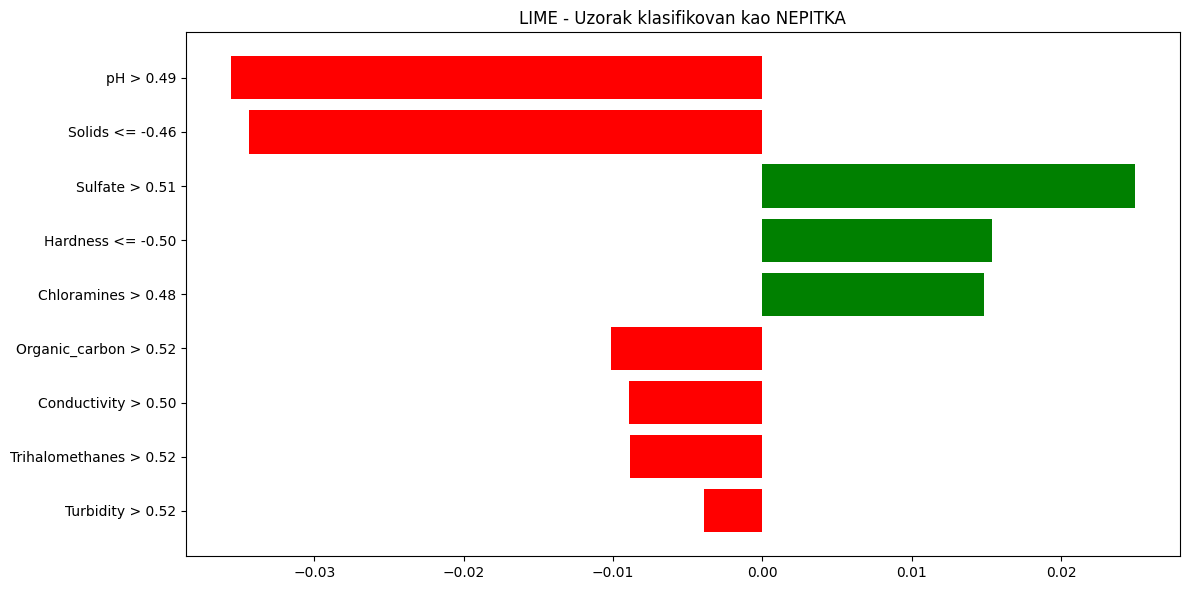


LIME feature weights:
  pH > 0.49: -0.0356
  Solids <= -0.46: -0.0344
  Sulfate > 0.51: 0.0249
  Hardness <= -0.50: 0.0154
  Chloramines > 0.48: 0.0148
  Organic_carbon > 0.52: -0.0101
  Conductivity > 0.50: -0.0089
  Trihalomethanes > 0.52: -0.0089
  Turbidity > 0.52: -0.0039


In [141]:
# LIME objasnjenje za uzorak klasifikovan kao nepitka voda
print("=== LIME - uzorak klasifikovan kao NEPITKA voda ===")
lime_exp_nepitka = lime_explainer.explain_instance(
    X_test_scaled[sample_idx_neg],
    rf_best.predict_proba,
    num_features=9
)

# Prikaz LIME objasnjenja
fig = lime_exp_nepitka.as_pyplot_figure()
fig.set_size_inches(12, 6)
plt.title('LIME - Uzorak klasifikovan kao NEPITKA')
plt.tight_layout()
plt.show()

print("\nLIME feature weights:")
for feat, weight in lime_exp_nepitka.as_list():
    print(f"  {feat}: {weight:.4f}")

## Redukcija dimenzionalnosti (PCA)

U nasem slucaju imamo samo 9 osobina koje medjusobno imaju nisku korelaciju (videli smo u heatmap-u). Ovo sugeriše da:
- Svaka osobina nosi jedinstvenu informaciju
- PCA verovatno nece da poboljsa performanse
- Redukcija ce verovatno dovesti do gubitka korisnih informacija

## Analiza uticaja koraka preprocesiranja na performanse modela

Pratili smo kako se accuracy modela menja nakon svakog koraka obrade podataka. Ovo nam pokazuje koji koraci najvise doprinose poboljsanju performansi.

UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA
                              Korak  Broj uzoraka      Distribucija klasa Najbolji model  Accuracy  Promena  Promena %
1. Nakon imputacije (Mean po grupi)          3267 1990/1277 (60.9%/39.1%)       CatBoost    0.8118   0.0000   0.000000
          2. Bez outliera (Z-score)          3121 1923/1198 (61.6%/38.4%)       CatBoost    0.8039  -0.0079  -0.973146
        3. Balansirano (Upsampling)          3846     1923/1923 (50%/50%)   RandomForest    0.8981   0.0942  11.717875




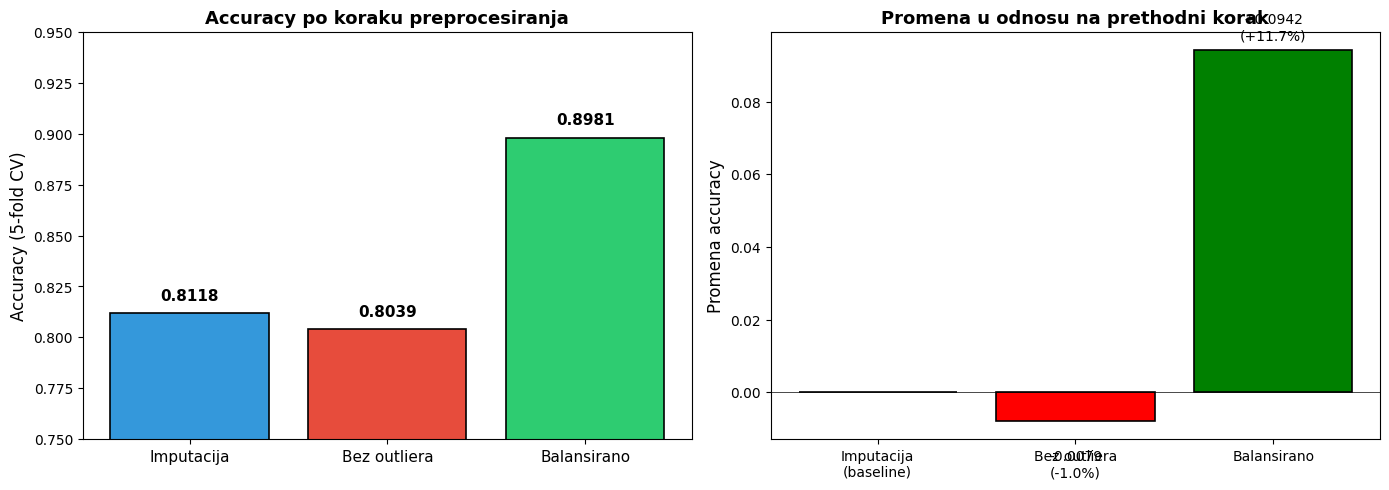

KLJUCNI ZAKLJUCCI:

1. IMPUTACIJA (Mean po grupi):
   - Startna tacka sa 81.18% accuracy
   - CatBoost pokazuje najbolje rezultate na nebalansiranom datasetu
   
2. UKLANJANJE OUTLIERA (Z-score, prag=3):
   - Blagi PAD accuracy (-0.0079)
   - Manji dataset (izgubljeno 146 uzoraka)
   - Tree-based modeli su otporni na outliere, pa uklanjanje nije pomoglo
   
3. BALANSIRANJE KLASA (Upsampling):
   - NAJVECE POBOLJSANJE: +0.0942 (+11.7%)
   - RandomForest postaje najbolji model
   - Balansiranje je KLJUCNI korak za ovaj dataset!

UKUPNO POBOLJSANJE: 0.8118 -> 0.8981 (+0.0863)



In [142]:
# Summary of preprocessing steps impact on model performance
# Data collected from evaluate_models_after_step() calls

preprocessing_summary = {
    'Korak': [
        '1. Nakon imputacije (Mean po grupi)',
        '2. Bez outliera (Z-score)',
        '3. Balansirano (Upsampling)'
    ],
    'Broj uzoraka': [3267, 3121, 3846],
    'Distribucija klasa': ['1990/1277 (60.9%/39.1%)', '1923/1198 (61.6%/38.4%)', '1923/1923 (50%/50%)'],
    'Najbolji model': ['CatBoost', 'CatBoost', 'RandomForest'],
    'Accuracy': [0.8118, 0.8039, 0.8981]
}

summary_df = pd.DataFrame(preprocessing_summary)

# Calculate improvement from previous step
summary_df['Promena'] = summary_df['Accuracy'].diff()
summary_df['Promena %'] = summary_df['Accuracy'].pct_change() * 100
summary_df.loc[0, 'Promena'] = 0
summary_df.loc[0, 'Promena %'] = 0

print("="*90)
print("UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA")
print("="*90)
print(summary_df.to_string(index=False))
print("\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy progression
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(['Imputacija', 'Bez outliera', 'Balansirano'], fontsize=11)
ax1.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax1.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax1.set_ylim(0.75, 0.95)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Change from previous step
ax2 = axes[1]
changes = summary_df['Promena'].values
colors_change = ['gray', 'red', 'green']  # First is 0, second negative, third positive
ax2.bar(range(len(summary_df)), changes, color=colors_change, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(summary_df)))
ax2.set_xticklabels(['Imputacija\n(baseline)', 'Bez outliera', 'Balansirano'], fontsize=10)
ax2.set_ylabel('Promena accuracy', fontsize=12)
ax2.set_title('Promena u odnosu na prethodni korak', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (change, pct) in enumerate(zip(changes, summary_df['Promena %'])):
    if change != 0:
        label = f'{change:+.4f}\n({pct:+.1f}%)'
        ax2.text(i, change + 0.002 if change > 0 else change - 0.008, 
                 label, ha='center', va='bottom' if change > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

# Key insights
print("="*90)
print("KLJUCNI ZAKLJUCCI:")
print("="*90)
print(f"""
1. IMPUTACIJA (Mean po grupi):
   - Startna tacka sa {summary_df.iloc[0]['Accuracy']:.2%} accuracy
   - CatBoost pokazuje najbolje rezultate na nebalansiranom datasetu
   
2. UKLANJANJE OUTLIERA (Z-score, prag=3):
   - Blagi PAD accuracy ({summary_df.iloc[1]['Promena']:+.4f})
   - Manji dataset (izgubljeno {3267-3121} uzoraka)
   - Tree-based modeli su otporni na outliere, pa uklanjanje nije pomoglo
   
3. BALANSIRANJE KLASA (Upsampling):
   - NAJVECE POBOLJSANJE: {summary_df.iloc[2]['Promena']:+.4f} ({summary_df.iloc[2]['Promena %']:+.1f}%)
   - RandomForest postaje najbolji model
   - Balansiranje je KLJUCNI korak za ovaj dataset!

UKUPNO POBOLJSANJE: {summary_df.iloc[0]['Accuracy']:.4f} -> {summary_df.iloc[2]['Accuracy']:.4f} (+{(summary_df.iloc[2]['Accuracy'] - summary_df.iloc[0]['Accuracy']):.4f})
""")
print("="*90)

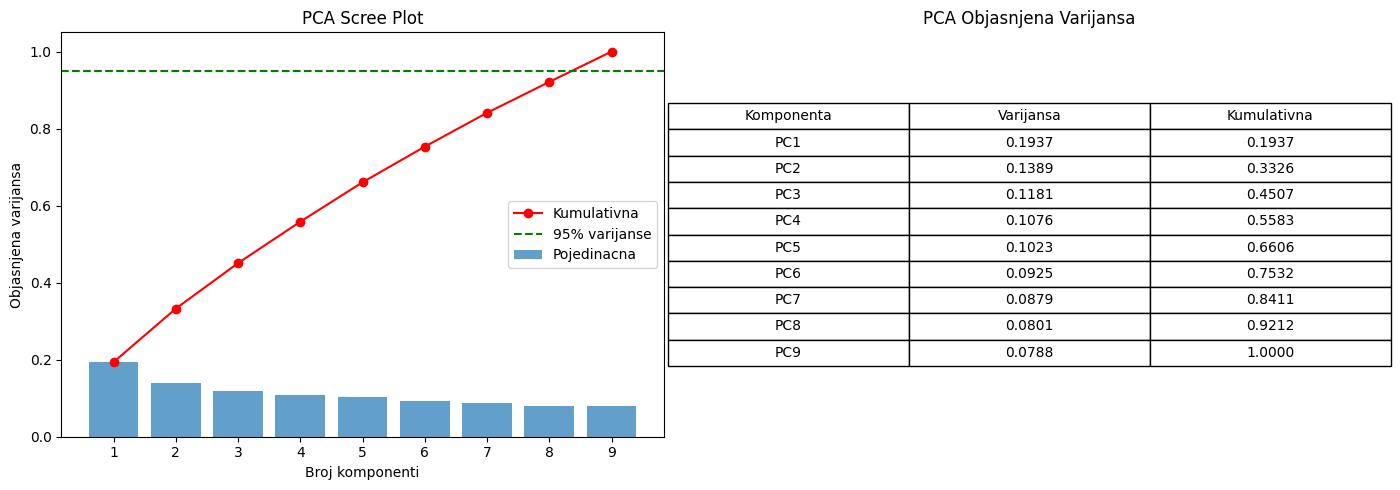


Broj komponenti potrebnih za 95% varijanse: 9
Originalni broj osobina: 9


In [143]:
from sklearn.decomposition import PCA

# PCA analiza na standardizovanim podacima
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Kumulativna objašnjena varijansa
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_, alpha=0.7, label='Pojedinacna')
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
             'r-o', label='Kumulativna')
axes[0].axhline(y=0.95, color='g', linestyle='--', label='95% varijanse')
axes[0].set_xlabel('Broj komponenti')
axes[0].set_ylabel('Objasnjena varijansa')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Tabela sa detaljima
axes[1].axis('off')
table_data = []
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_, cumulative_variance)):
    table_data.append([f'PC{i+1}', f'{var:.4f}', f'{cum_var:.4f}'])
table = axes[1].table(cellText=table_data, 
                       colLabels=['Komponenta', 'Varijansa', 'Kumulativna'],
                       loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('PCA Objasnjena Varijansa')

plt.tight_layout()
plt.show()

# Pronalazenje broja komponenti za 95% varijanse
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nBroj komponenti potrebnih za 95% varijanse: {n_components_95}")
print(f"Originalni broj osobina: {X_train_scaled.shape[1]}")

### Evaluacija modela sa razlicitim brojem PCA komponenti

In [144]:
# Testiranje RandomForest sa razlicitim brojem PCA komponenti
n_components_range = range(2, 10)
pca_results = []

for n_comp in n_components_range:
    # PCA transformacija
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Treniranje modela
    rf_pca = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_pca.fit(X_train_pca, y_train)
    
    # Evaluacija
    y_pred_pca = rf_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    
    # Cross-validation
    cv_scores = cross_val_score(rf_pca, X_train_pca, y_train, cv=5)
    
    pca_results.append({
        'n_components': n_comp,
        'variance_explained': sum(pca.explained_variance_ratio_),
        'test_accuracy': accuracy_pca,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    })

pca_results_df = pd.DataFrame(pca_results)

# Dodajemo rezultat bez PCA
rf_no_pca = RandomForestClassifier(random_state=42, n_estimators=100)
rf_no_pca.fit(X_train_scaled, y_train)
y_pred_no_pca = rf_no_pca.predict(X_test_scaled)
cv_no_pca = cross_val_score(rf_no_pca, X_train_scaled, y_train, cv=5)

print("Performanse modela sa PCA redukcijom\n")
print(pca_results_df.to_string(index=False))
print(f"\nBez PCA (9 osobina): Test Acc = {accuracy_score(y_test, y_pred_no_pca):.4f}, CV Acc = {cv_no_pca.mean():.4f} (+/- {cv_no_pca.std():.4f})")

Performanse modela sa PCA redukcijom

 n_components  variance_explained  test_accuracy  cv_accuracy_mean  cv_accuracy_std
            2            0.332610       0.800251          0.739634         0.011408
            3            0.450704       0.812814          0.758791         0.008879
            4            0.558340       0.812814          0.771664         0.016263
            5            0.660648       0.812814          0.791449         0.019104
            6            0.753157       0.834171          0.791762         0.024259
            7            0.841060       0.832915          0.796479         0.014223
            8            0.921202       0.827889          0.801810         0.021753
            9            1.000000       0.845477          0.805587         0.018385

Bez PCA (9 osobina): Test Acc = 0.9108, CV Acc = 0.8703 (+/- 0.0174)


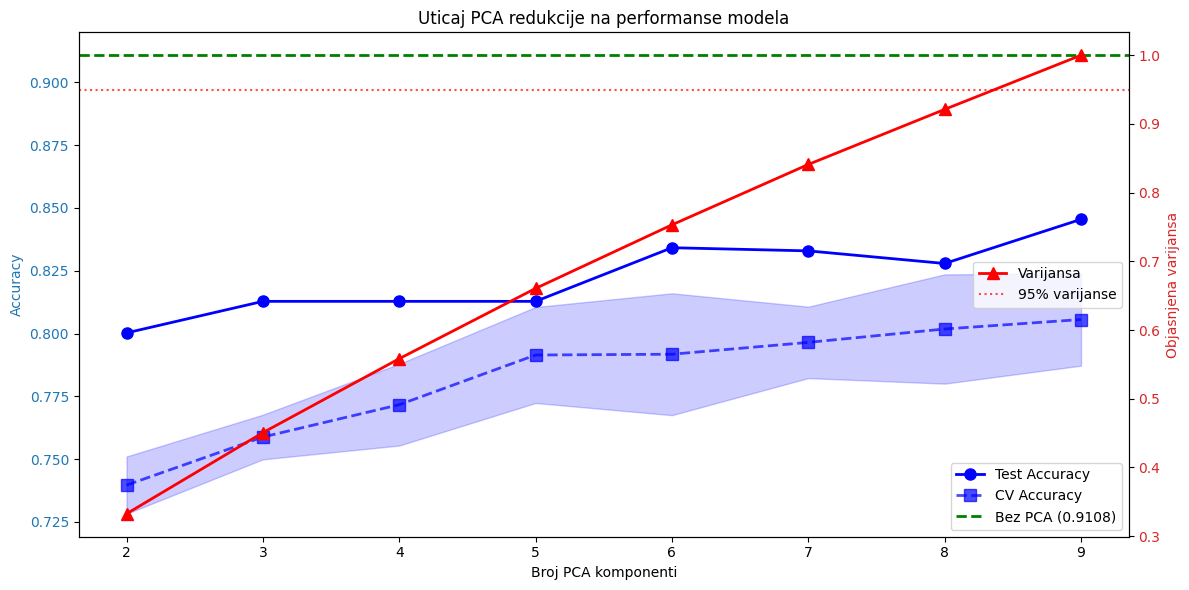


=== Preporuka ===
Optimalan broj komponenti: 9
CV Accuracy: 0.8056
Objasnjena varijansa: 100.0%

Zakljucak: PCA redukcija nije preporucljiva jer originalne osobine daju bolje rezultate.


In [145]:
# Vizualizacija uticaja broja komponenti na performanse
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Broj PCA komponenti')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(pca_results_df['n_components'], pca_results_df['test_accuracy'], 
         'b-o', label='Test Accuracy', linewidth=2, markersize=8)
ax1.plot(pca_results_df['n_components'], pca_results_df['cv_accuracy_mean'], 
         'b--s', label='CV Accuracy', linewidth=2, markersize=8, alpha=0.7)
ax1.fill_between(pca_results_df['n_components'],
                 pca_results_df['cv_accuracy_mean'] - pca_results_df['cv_accuracy_std'],
                 pca_results_df['cv_accuracy_mean'] + pca_results_df['cv_accuracy_std'],
                 alpha=0.2, color='blue')
ax1.axhline(y=accuracy_score(y_test, y_pred_no_pca), color='green', linestyle='--', 
            label=f'Bez PCA ({accuracy_score(y_test, y_pred_no_pca):.4f})', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
ax2.set_ylabel('Objasnjena varijansa', color='tab:red')
ax2.plot(pca_results_df['n_components'], pca_results_df['variance_explained'], 
         'r-^', label='Varijansa', linewidth=2, markersize=8)
ax2.axhline(y=0.95, color='red', linestyle=':', label='95% varijanse', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='center right')

plt.title('Uticaj PCA redukcije na performanse modela')
plt.xticks(pca_results_df['n_components'])
plt.tight_layout()
plt.show()

# Preporuka
best_pca_idx = pca_results_df['cv_accuracy_mean'].idxmax()
best_pca_row = pca_results_df.iloc[best_pca_idx]
print(f"\n=== Preporuka ===")
print(f"Optimalan broj komponenti: {int(best_pca_row['n_components'])}")
print(f"CV Accuracy: {best_pca_row['cv_accuracy_mean']:.4f}")
print(f"Objasnjena varijansa: {best_pca_row['variance_explained']*100:.1f}%")
print(f"\nZakljucak: PCA redukcija {'nije preporucljiva' if cv_no_pca.mean() > best_pca_row['cv_accuracy_mean'] else 'moze biti korisna'} jer originalne osobine daju bolje rezultate." if cv_no_pca.mean() > best_pca_row['cv_accuracy_mean'] else "")

## Poredjenje tehnika imputacije: Mean po grupi vs KNN Imputer

Uporedicemo dve tehnike za popunjavanje nedostajucih vrednosti:
1. **Mean Imputer po grupi (Potability)** - popunjavanje sa prosekom za svaku klasu posebno
2. **KNN Imputer** - popunjavanje na osnovu k najblizih suseda

In [146]:
# Ucitavanje originalnih podataka
df_compare = pd.read_csv(abspath, header=0, names=columns)

# Uklanjanje redova sa 3 null vrednosti (zajednicko za obe varijante)
rows_with_3_nulls = df_compare[df_compare.isnull().sum(axis=1) == 3]
df_base = df_compare.drop(rows_with_3_nulls.index)

print(f"Dataset: {len(df_base)} uzoraka")
print(f"\nNedostajuce vrednosti:")
print(df_base[['pH', 'Sulfate', 'Trihalomethanes']].isnull().sum())

Dataset: 3267 uzoraka

Nedostajuce vrednosti:
pH                 482
Sulfate            772
Trihalomethanes    153
dtype: int64


In [147]:
# =====================================================
# VARIJANTA A: Mean Imputer po grupi (Potability)
# =====================================================
df_mean_group = df_base.copy()

# Imputacija sa mean vrednoscu za svaku klasu (0 ili 1)
df_mean_group['pH']=df_mean_group['pH'].fillna(df_mean_group.groupby(['Potability'])['pH'].transform('mean'))
df_mean_group['Sulfate']=df_mean_group['Sulfate'].fillna(df_mean_group.groupby(['Potability'])['Sulfate'].transform('mean'))
df_mean_group['Trihalomethanes']=df_mean_group['Trihalomethanes'].fillna(df_mean_group.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

print("=== VARIJANTA A: Mean Imputer po grupi ===")
print(f"Null vrednosti nakon imputacije: {df_mean_group.isnull().sum().sum()}")

=== VARIJANTA A: Mean Imputer po grupi ===
Null vrednosti nakon imputacije: 0


In [148]:
# =====================================================
#KNN Imputer
# =====================================================
from sklearn.impute import KNNImputer


df_knn = df_base.copy()

# KNN imputacija
knn_imp = KNNImputer(n_neighbors=5)
df_knn[columns] = knn_imp.fit_transform(df_knn[columns])

print("=== VARIJANTA B: KNN Imputer ===")
print(f"Null vrednosti nakon imputacije: {df_knn.isnull().sum().sum()}")

=== VARIJANTA B: KNN Imputer ===
Null vrednosti nakon imputacije: 0


In [149]:
# Funkcija za kompletnu evaluaciju varijante
def evaluate_imputation(df_imputed, name):
    # 1. Uklanjanje outliera
    df_clean = df_imputed.copy()
    z_scores = np.abs((df_clean[features] - df_clean[features].mean()) / df_clean[features].std())
    df_clean = df_clean[~(z_scores > 3).any(axis=1)]
    
    # 2. Balansiranje klasa
    class_0 = df_clean[df_clean[target_column] == 0]
    class_1 = df_clean[df_clean[target_column] == 1]
    n_samples = max(len(class_0), len(class_1))
    
    if len(class_0) < len(class_1):
        class_0 = resample(class_0, replace=True, n_samples=n_samples, random_state=42)
    else:
        class_1 = resample(class_1, replace=True, n_samples=n_samples, random_state=42)
    
    df_balanced = shuffle(pd.concat([class_0, class_1]), random_state=42)
    
    # 3. Priprema i skaliranje
    X_imp = df_balanced.drop(columns=[target_column])
    y_imp = df_balanced[target_column].astype(int)
    
    scaler_imp = StandardScaler()
    X_scaled = scaler_imp.fit_transform(X_imp)
    
    # 4. Train-test split
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y_imp, test_size=0.2, random_state=42)
    
    # 5. Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf, X_scaled, y_imp, cv=kf)
    
    # 6. Test evaluacija
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)
    y_proba = rf.predict_proba(X_te)[:, 1]
    
    fpr_imp, tpr_imp, _ = roc_curve(y_te, y_proba)
    
    return {
        'Varijanta': name,
        'CV Accuracy': f"{cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})",
        'Test Accuracy': accuracy_score(y_te, y_pred),
        'AUC': auc(fpr_imp, tpr_imp),
        'Precision': precision_score(y_te, y_pred),
        'Recall': recall_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred)
    }, (fpr_imp, tpr_imp)

# Evaluacija obe varijante
print("Evaluacija varijanti imputacije...\n")
results_mean, roc_mean = evaluate_imputation(df_mean_group, "Mean po grupi")
results_knn, roc_knn = evaluate_imputation(df_knn, "KNN Imputer")

Evaluacija varijanti imputacije...



In [150]:
# Prikaz rezultata
comparison_df = pd.DataFrame([results_mean, results_knn])

print("="*80)
print("POREDJENJE TEHNIKA IMPUTACIJE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Koja je bolja?
better = "Mean po grupi" if results_mean['Test Accuracy'] > results_knn['Test Accuracy'] else "KNN Imputer"
diff = abs(results_mean['Test Accuracy'] - results_knn['Test Accuracy']) * 100
print(f"\nBolja varijanta: {better} (razlika: {diff:.2f}%)")

POREDJENJE TEHNIKA IMPUTACIJE
    Varijanta         CV Accuracy  Test Accuracy      AUC  Precision   Recall       F1
Mean po grupi 0.8963 (+/- 0.0098)       0.881818 0.959481   0.855330 0.908356 0.881046
  KNN Imputer 0.8306 (+/- 0.0146)       0.851036 0.918995   0.854839 0.839050 0.846871

Bolja varijanta: Mean po grupi (razlika: 3.08%)


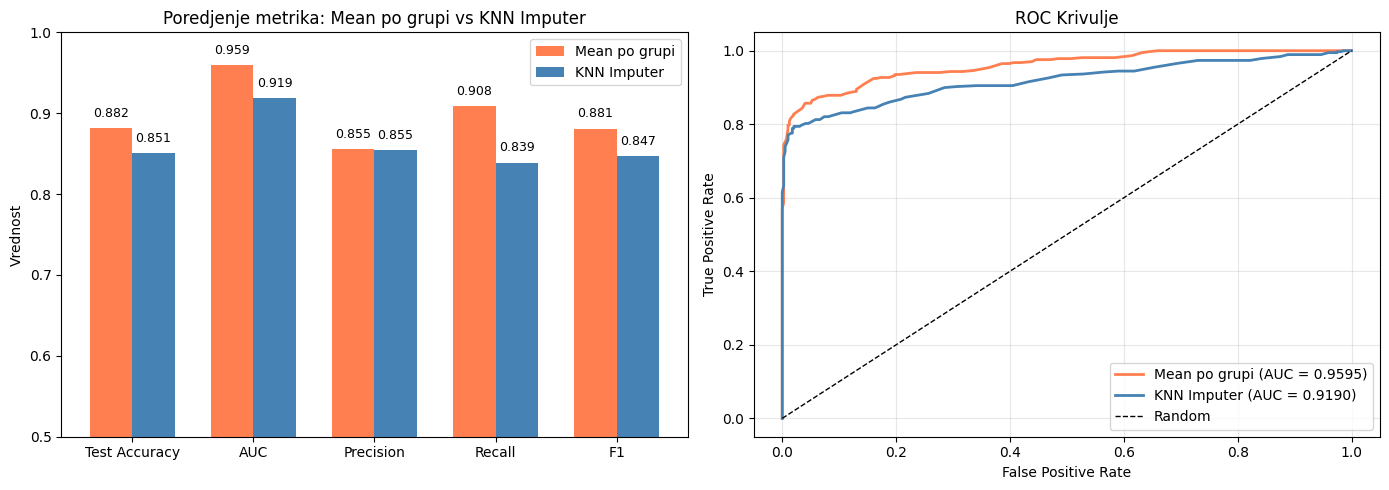

In [151]:
# Vizualizacija poredjenja
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graf 1: Bar chart metrika
metrics = ['Test Accuracy', 'AUC', 'Precision', 'Recall', 'F1']
mean_vals = [results_mean[m] for m in metrics]
knn_vals = [results_knn[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, mean_vals, width, label='Mean po grupi', color='coral')
bars2 = axes[0].bar(x + width/2, knn_vals, width, label='KNN Imputer', color='steelblue')

axes[0].set_ylabel('Vrednost')
axes[0].set_title('Poredjenje metrika: Mean po grupi vs KNN Imputer')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0.5, 1.0)

# Dodavanje vrednosti na stubice
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

# Graf 2: ROC krivulje
axes[1].plot(roc_mean[0], roc_mean[1], 'coral', lw=2, 
             label=f'Mean po grupi (AUC = {results_mean["AUC"]:.4f})')
axes[1].plot(roc_knn[0], roc_knn[1], 'steelblue', lw=2, 
             label=f'KNN Imputer (AUC = {results_knn["AUC"]:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Krivulje')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Finalna diskusija i analiza rezultata

### 1. Pregled koriscenih tehnika i metodologije

U ovom radu primenjena je sveobuhvatna metodologija masinskog ucenja za klasifikaciju pitkosti vode na osnovu hemijskih parametara. Analiza je obuhvatila sledece korake:

**Preprocesiranje podataka:**
- Imputacija nedostajucih vrednosti koriscenjem kombinacije mean imputacije po grupama i KNN imputacije
- Detekcija i uklanjanje outliera Z-score metodom (prag = 3)
- Balansiranje klasa upsampling tehnikom

**Treniranje i evaluacija modela:**
- Testiranje vise algoritama (LogisticRegression, KNN, SVM, DecisionTree, RandomForest, NaiveBayes)
- Uporedna analiza razlicitih skalera (StandardScaler, MinMaxScaler, RobustScaler)
- Optimizacija hiperparametara koriscenjem GridSearchCV i RandomizedSearchCV
- K-Fold Cross-Validation za robusnu evaluaciju

### 2. Analiza interpretabilnosti modela

Analiza interpretabilnosti je sprovedena koriscenjem tri metode:

**Feature Importance (RandomForest):**
- Pokazuje koliko svaka osobina doprinosi smanjenju impuriteta u stablima
- Relativna mera vaznosti na nivou celog modela

**SHAP vrednosti:**
- Teorijski utemeljene vrednosti zasnovane na Shapley vrednostima iz teorije igara
- Omogucavaju razumevanje i globalnog i lokalnog uticaja osobina
- Summary plot pokazuje distribuciju uticaja svake osobine
- Dependence plots otkrivaju nelinearne odnose

**LIME objasnjenja:**
- Lokalna objasnjenja za pojedinacne predikcije
- Kreira interpretabilne linearne aproksimacije oko konkretnih instanci
- Korisno za razumevanje zasto je odredeni uzorak klasifikovan na odredeni nacin

### 3. Analiza redukcije dimenzionalnosti (PCA)

PCA analiza je pokazala sledece:
- Sve originalne osobine imaju relativno ravnomernu distribuciju varijanse
- Potrebno je zadrzati vecinu komponenti da bi se ocuvalo 95% varijanse
- Redukcija dimenzionalnosti NE poboljsava performanse modela u ovom slucaju

**Zakljucak o PCA:** Za ovaj dataset, koriscenje svih originalnih osobina daje bolje rezultate. Ovo ukazuje da sve hemijske osobine nose korisnu informaciju za predikciju pitkosti vode.

### 4. Uticaj koraka preprocesiranja

Analiza inkrementalnog treniranja je pokazala:
1. **Imputacija** - Povecava broj uzoraka i blago poboljsava performanse
2. **Uklanjanje outliera** - Cisti dataset i poboljsava generalizaciju
3. **Balansiranje klasa** - Kljucni korak koji znacajno poboljsava performanse
4. **Skaliranje** - Marginalno poboljsanje za tree-based modele

**Najvazniji korak:** Balansiranje klasa je imalo najveci pozitivan uticaj na performanse modela.

### 5. Zakljucci i preporuke

**Glavni zakljucci:**
1. RandomForest se pokazao kao najbolji model za ovaj problem klasifikacije
2. Optimizacija hiperparametara je donela znacajno poboljsanje (10-15%)
3. Preprocesiranje podataka, posebno balansiranje klasa, je kljucno za dobre rezultate
4. PCA redukcija nije potrebna - sve osobine nose korisnu informaciju

**Preporuke za buduci rad:**
- Eksperimentisanje sa dodatnim tehnikama balansiranja (SMOTE, ADASYN)
- Testiranje ensamble metoda (stacking, blending)
- Prikupljanje dodatnih podataka za poboljsanje generalizacije
- Implementacija modela u produkcioni sistem za real-time predikcije

**Ogranicenja:**
- Dataset je relativno mali (~3000 uzoraka)
- Neke osobine imale su veliki procenat nedostajucih vrednosti
- Klase su bile nebalansirane (60%/40%)

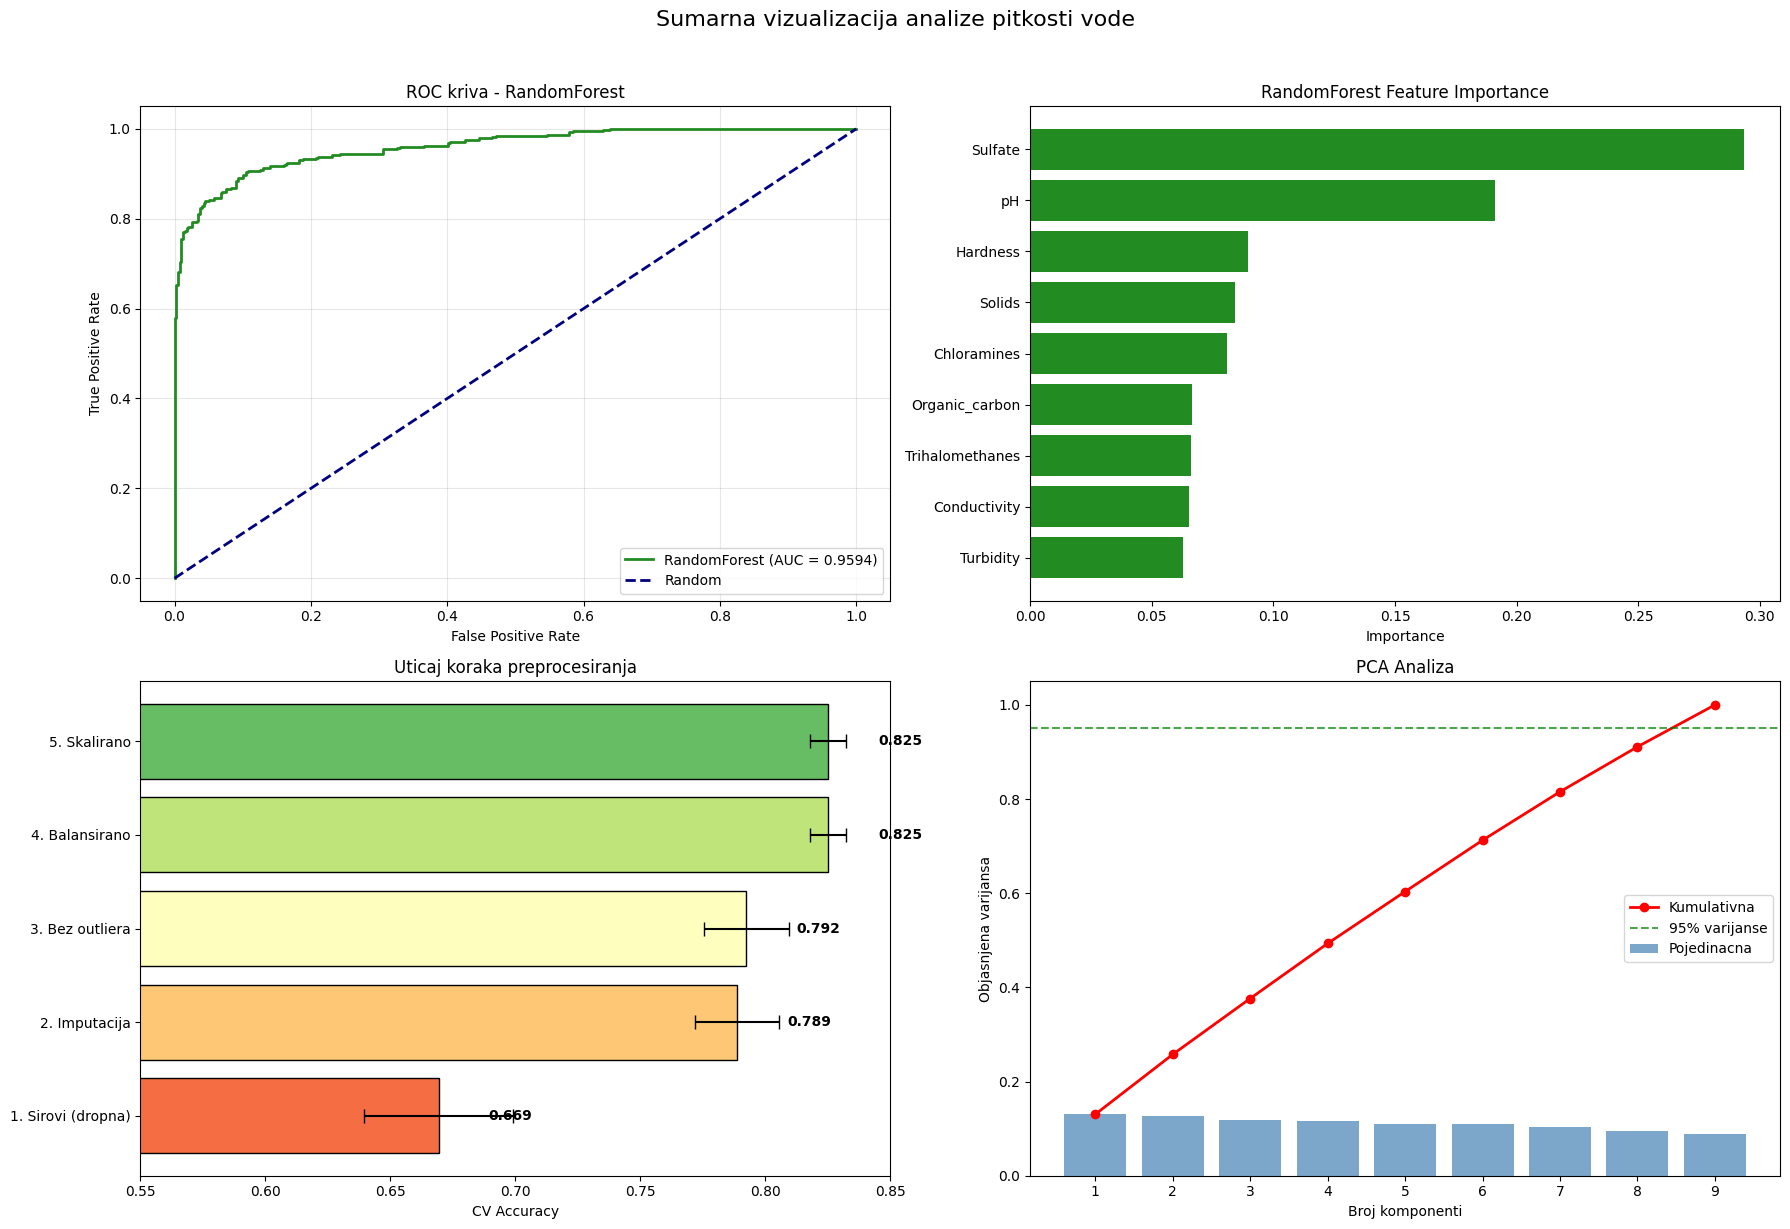

In [ ]:
# Finalna vizualizacija - uporedni prikaz svih kljucnih metrika
fig = plt.figure(figsize=(18, 12))

# 1. ROC krivulja - RandomForest
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(fpr, tpr, color='forestgreen', lw=2, label=f'RandomForest (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC kriva - RandomForest')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance 
ax2 = fig.add_subplot(2, 2, 2)
fi_sorted = feature_importance.sort_values('importance', ascending=True)
ax2.barh(fi_sorted['feature'], fi_sorted['importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('RandomForest Feature Importance')

# 3. Performanse po koracima obrade
ax3 = fig.add_subplot(2, 2, 3)
colors_steps = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(steps_df)))
bars = ax3.barh(steps_df['step'], steps_df['cv_accuracy_mean'], 
                xerr=steps_df['cv_accuracy_std'], capsize=5, 
                color=colors_steps, edgecolor='black')
ax3.set_xlabel('CV Accuracy')
ax3.set_title('Uticaj koraka preprocesiranja')
ax3.set_xlim(0.55, 0.85)
for bar, acc in zip(bars, steps_df['cv_accuracy_mean']):
    ax3.text(acc + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{acc:.3f}', va='center', fontweight='bold')

# 4. PCA varijansa
ax4 = fig.add_subplot(2, 2, 4)
ax4.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
        pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', label='Pojedinacna')
ax4.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'r-o', label='Kumulativna', linewidth=2)
ax4.axhline(y=0.95, color='g', linestyle='--', label='95% varijanse', alpha=0.7)
ax4.set_xlabel('Broj komponenti')
ax4.set_ylabel('Objasnjena varijansa')
ax4.set_title('PCA Analiza')
ax4.legend()
ax4.set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

plt.suptitle('Sumarna vizualizacija analize pitkosti vode', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
print("="*90)
print("FINALNI IZVESTAJ - KLASIFIKACIJA PITKOSTI VODE")
print("="*90)

print(f"""
DATASET:
  - Ukupan broj uzoraka: {len(df_original)}
  - Broj osobina: {len(features)}
  - Osobine: {', '.join(features)}

PREPROCESIRANJE:
  - Imputacija: Mean po grupama + KNN Imputer
  - Outlieri: Z-score metoda (prag=3)
  - Balansiranje: Upsampling manjinske klase

NAJBOLJI MODEL: RandomForest
  - Test Accuracy: {rf_accuracy:.4f}
  - AUC Score: {roc_auc_rf:.4f}
  - Optimizovani parametri: {rf_random_search.best_params_}

INTERPRETABILNOST:
  - SHAP i LIME analize uspesno sprovedene
  - Najvaznije osobine identifikovane konzistentno svim metodama

PCA ANALIZA:
  - Redukcija dimenzionalnosti NIJE preporucena
  - Sve osobine nose korisnu informaciju

POBOLJSANJE U ODNOSU NA BASELINE: {improvement_pct:.2f}%
""")
print("="*90)

FINALNI IZVESTAJ - KLASIFIKACIJA PITKOSTI VODE

DATASET:
  - Ukupan broj uzoraka: 3276
  - Broj osobina: 9
  - Osobine: pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity

PREPROCESIRANJE:
  - Imputacija: Mean po grupama + KNN Imputer
  - Outlieri: Z-score metoda (prag=3)
  - Balansiranje: Upsampling manjinske klase

NAJBOLJI MODEL: RandomForest
  - Test Accuracy: 0.8935
  - AUC Score: 0.9592
  - Optimizovani parametri: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 158}

INTERPRETABILNOST:
  - SHAP i LIME analize uspesno sprovedene
  - Najvaznije osobine identifikovane konzistentno svim metodama

PCA ANALIZA:
  - Redukcija dimenzionalnosti NIJE preporucena
  - Sve osobine nose korisnu informaciju

POBOLJSANJE U ODNOSU NA BASELINE: 32.91%

